






<img src="pirate.png">















<h1 align="center">The Rockin' Pirate Guns</h1>

<h3 align="center"><b>T</b>homas Atkins, <b>R</b>on Cordell, <b>P</b>atrick Ng, <b>G</b>unnar Kleemann</h3>

**W207_3 machine learning Final group Rossman competition Forecast sales using store, promotion, and competitor data**
Rossmann operates over 3,000 drug stores in 7 European countries. Currently, Rossmann store managers are tasked with predicting their daily sales for up to six weeks in advance. Store sales are influenced by many factors, including promotions, competition, school and state holidays, seasonality, and locality. With thousands of individual managers predicting sales based on their unique circumstances, the accuracy of results can be quite varied.
In their first Kaggle competition, Rossmann is challenging you to predict 6 weeks of daily sales for 1,115 stores located across Germany. Reliable sales forecasts enable store managers to create effective staff schedules that increase productivity and motivation. By helping Rossmann create a robust prediction model, you will help store managers stay focused on what’s most important to them: their customers and their teams!
If you are interested in joining Rossmann at their headquarters near Hanover, Germany, please contact Mr. Frank König (Frank.Koenig {at} rossmann.de) Rossmann is currently recruiting data scientists at senior and entry-level positions.
https://www.kaggle.com/c/rossmann-store-sales

Started: 12:02 pm, Wednesday 30 September 2015 UTC 

Ends: 11:59 pm, Monday 14 December 2015 UTC (75 total days) 

Points: this competition awards standard ranking points Tiers: this competition counts towards tiers


Issues page: https://github.com/MIDS-W207/2015_fall_coursework/issues

In [8]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.dates
import matplotlib.cm as cm

import seaborn as sns
sns.set_style('whitegrid')
import matplotlib.dates as dates
import matplotlib.dates as mdates
from matplotlib.dates import MonthLocator, WeekdayLocator, DateFormatter

import datetime
import operator

import pandas as pd
from pandas import Series,DataFrame

import random
import numpy as np
import csv
from scipy import sparse
import time

from sklearn import preprocessing
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn import naive_bayes
from sklearn import svm


# Define Functions

In [9]:


def MergeTheDfs (train_df, store_df):
    #For each store, find its first opening day and merge it into store_df
    train_by_Store_df = train_df.groupby('Store')
    storeOpenDays = train_by_Store_df['Date2'].min()

    d = pd.DataFrame(storeOpenDays)
    d = d.rename(columns = {'Date2':'OpenDay'})
    store_df = pd.merge(store_df, d, left_on = 'Store', right_index = True) 
    
    #For each store, convert it's competitor open day into a Date column
    competitorOpenDay = store_df.apply(lambda row: np.nan 
            if pd.isnull(row['CompetitionOpenSinceMonth']) or pd.isnull(row['CompetitionOpenSinceYear'])
            else np.datetime64("%d-%02d-01" % (int(row['CompetitionOpenSinceYear']), int(row['CompetitionOpenSinceMonth']))), 
            axis=1)
    store_df["CompetitorOpenDay"] = competitorOpenDay

    # For those stores with empty CompetitorOpenDay date, set it to the same as StoreOpenDay
    store_df.ix[:, 'CompetitorOpenDay'] = store_df["CompetitorOpenDay"].fillna(store_df['OpenDay'])
    #store_df.ix[:,['CompetitorOpenDay', 'OpenDay']]

    # Merge store data into train data
    train_df = pd.merge(train_df, store_df, on="Store")
    
    # Use Date as the index.  This will make exploration much easier.
    #train_df = train_df.set_index('Date')
    return [train_df, store_df]

def quantLevel(df, ColNameLs=['Open', 'StateHoliday', 'SchoolHoliday', 'Promo']):
    # Display percentage of unique values of these fields
    for col in ColNameLs:
        sizes = df.groupby(col).size()
        print sizes / sizes.sum()
        print
    
def rmspe(y, yhat):
    y = y.astype('float')
    yhat = yhat.astype('float')
    inner = ((y-yhat)/y)**2
    return (np.mean(inner))**0.5


  
def BoxPlotGroupBy(data, y, group, axis):
    ax = sns.boxplot(data[y], groupby = data[group], 
                     order = np.sort(pd.unique(data[group])), ax = axis)
    txt = ax.set_title(y + " grouped by " + group) 
    if axis is None:
        plt.show()
        
        
def SalesSlopes(storeDt, trainDt):
    storeDt['Slope'] = np.empty(len(storeDt)) * np.nan
    ts = trainDt.sort_index()
    variables=['Customers','Sales']
    
    for i in range(1, len(ts['Store'].unique())):
        if i%100 == 0:
            print 'up to store number' + str(i) 
        ts1 = trainDt[trainDt.Store == i] 
        xd=ts1.Customers
        yd=ts1.Sales
        #
        #xd='ts1.' + variables[0]
        #yd='ts1.' + variables[1]
        par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

        # add slope to store data
        slope=par[0][0]
        storeDt['Slope'][storeDt['Store'] == i]=slope
    return storeDt    


def TrendStats(plot_df):
    ## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    xd=plot_df.Customers
    yd=plot_df.Sales
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(Xbound/15,Ybound*.85,'$R^2 = %0.2f$'% Rsqr, fontsize=15)
    plt.text(Xbound/15,Ybound*.7,'$m = %0.2f$'% slope, fontsize=15)
    plt.plot(xl, yl, '-r')

def PlotAvgSalesByGroup(group, storeId=None, dim=None, daily=False, marker='o', alpha=0.7, **kwargs):
    stores = [None]
    if type(storeId) is list:
        stores = storeId
    else:
        stores = [storeId]
        
    if dim is None:
        dim = [1, len(stores)]
        
    fig, axises = plt.subplots(dim[0], dim[1], figsize=(15,3 * dim[0]))
    if len(stores) == 1:
        axises = [axises]
    else:
        axises = axises.ravel()

    for store, axis in zip(stores, axises):
        if store is None:
            df = train_data2.set_index('Date2')
            title = None
        else:
            df = train_data2[train_data2['Store'] == store]
            title = 'Store ' + str(store)

        train_df_by_group = df.groupby(group)
        colors = cm.rainbow(np.linspace(0, 1, len(train_df_by_group)))
        labels = []

        if not daily:
            monthly_data = train_df_by_group.resample('M', how='mean')

            for groupItem, c in zip(train_df_by_group.groups.keys(), colors):
                # Note: Here we use .loc instead of .ix, otherwise will have problem if groupItem is an integer, as
                #       df.ix[[0]] will give you the first row instead of the first level of a multi-index df
                ax = monthly_data.loc[[groupItem]].plot(y='Sales', ax=axis, marker=marker,
                         legend=False, label=None, color=c, rot=0, alpha=alpha, **kwargs)

                labels.append(str(group) + " = " + str(groupItem))

            dateRange = pd.date_range(train_data2.index.min(), train_data2.index.max(), freq='M')
            axis.set_xticks(range(len(dateRange)))
            axis.set_xticklabels(["%d-%02d" % (x.year, x.month) for x in dateRange], rotation=90)
        else:
            for groupItem, c in zip(train_df_by_group.groups.keys(), colors):
                d = train_df_by_group.get_group(groupItem).sort_index()
                ax = axis.plot_date(x=d.index.tolist(), y=d['Sales'].tolist(), color=c, marker=marker, 
                                    alpha=alpha, **kwargs)
                labels.append(str(group) + " = " + str(groupItem))

            axis.xaxis.set_major_locator(MonthLocator(range(1, 13), bymonthday=1, interval=1))
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
            fig.autofmt_xdate(rotation=90)
            plt.grid(True)

        axis.legend(labels, loc = 2, numpoints = 1)
        if title is not None:
            axis.set_title(title)   
            
            
                 
def getDayDiff(data, start, end):
    idxLs=range(len(data))
    df = pd.DataFrame(np.nan, index=idxLs, columns=['CumlDays'])
    #DayDiff = test_data2.index-test_data2.OpenDay
    DayDiff = end-start
    for i in range(len(DayDiff)):
        if i%1000==0:  # print output every 1000  
            print 'before assign ' + str(DayDiff[i])
            #print df
        df['CumlDays'][i]=int(str(DayDiff[i]).split(' ')[0])
        if i%1000==0:  # print output every 1000  
            #str(CumlDays[i]).split(' ')[0]
            print 'After assign ' + str(df['CumlDays'][i])
    #data=data + df['CumlDays']  
    #print data
    return data



## Wrangle the data

In [10]:
train_data = pd.read_csv('train.csv') #~/Development/kaggle/rossman/data/
test_data = pd.read_csv('test.csv') #~/Development/kaggle/rossman/data/
store_data = pd.read_csv('store.csv') #~/Development/kaggle/rossman/data/

# Convert the date column in train and test data
train_data['Date'] = pd.to_datetime(train_data['Date'], format="%Y-%m-%d")
test_data['Date'] = pd.to_datetime(test_data['Date'], format="%Y-%m-%d")

# Use Date as the index.  This will make exploration much easier.
train_data['Date2'] = train_data['Date']
test_data['Date2'] = test_data['Date']

train_data = train_data.set_index('Date')
test_data = test_data.set_index('Date')

In [11]:

# Fixing column 7 errors it by change all 0 to '0'
train_data.loc[train_data['StateHoliday'] == 0, 'StateHoliday'] = '0'


###Closed Stores####
# Closed stores are dont sell anything. Closed stores comprise ~15% of the test set. 
# According to the board closed store predictions do not count toward the score.

#Keep only records where the store is open
train_data = train_data.loc[train_data['Open'] == 1]
test_data = test_data.loc[test_data['Open'] == 1]

# Keep only records with non-zero sales
train_data = train_data.loc[train_data['Sales'] > 0]
train_data = train_data.loc[train_data['Sales'] > 0]

# remove open since it is not used
test_data.drop('Open', axis=1, inplace='true')
train_data.drop('Open', axis=1, inplace='true')


#add a month column
train_data['month']=train_data['Date2'].dt.month
test_data['month']=test_data['Date2'].dt.month


# merge everything
data=MergeTheDfs (train_data, store_data)
train_data2=data[0]
store_data2=data[1]

data=MergeTheDfs (test_data, store_data)
test_data2=data[0]


# fill in 0 when there is NAN
train_data2.fillna(0, inplace=True)
test_data2.fillna(0, inplace=True)

# Check the data

In [ ]:
print ('\n')
print 'store data'
print ('\n')
store_data2.info()
print ('\n')
print 'train data'
print ('\n')
train_data2.info()
print ('\n')
print 'test data'
print ('\n')
test_data2.info()


## 1- Feature exploration and enginering 


# look across stores to get an idea of differences

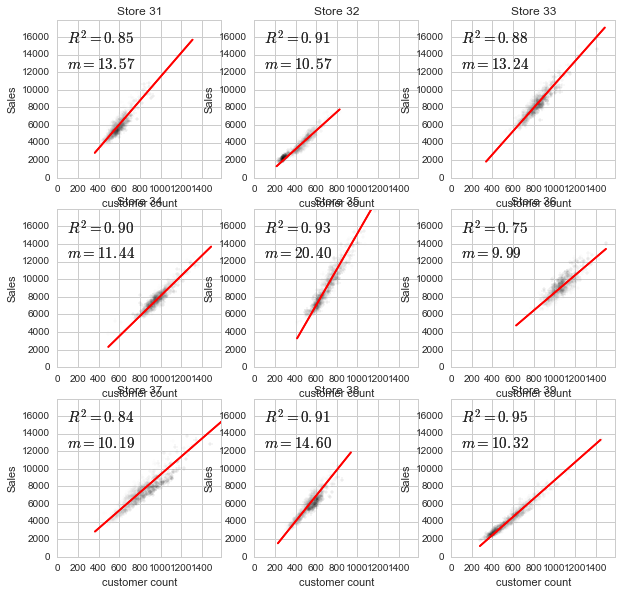

In [13]:
ts = train_data2.sort_index() # sort by date 
num_plots = 9
plt.figure(figsize=(10,num_plots*10/3))

starting_store = 31
# set uniform axis so most stores fit in 
Xbound=np.percentile(ts.Customers, 95)
Ybound=np.percentile(ts.Sales, 99)

for i in range(0, num_plots):
    plot_df = ts.loc[ts['Store'] == i + starting_store]
    #plot_df = ts1[ts1['Sales'] > 500]
    colors = plot_df.DayOfWeek
    plt.subplot(num_plots, 3, i + 1)
    #plt.axis('off')
    plt.title('Store {0}'.format(starting_store + i))
    plt.scatter(plot_df.Customers, plot_df.Sales, s=20, marker= "+", c=colors, alpha=.25)
    # I am not sure why I have lost the ability to control marker size/ color above
    plt.axis([0, Xbound+150, 0, Ybound+150]) 

    plt.ylabel('Sales')
    plt.xlabel('customer count')
    
    ## ADD A BEST FIT LINE from - http://stackoverflow.com/questions/22239691/code-for-line-of-best-fit-of-a-scatter-plot-in-python
    xd=plot_df.Customers
    yd=plot_df.Sales
    par = np.polyfit(xd, yd, 1, full=True) # determine best fit line

    slope=par[0][0]
    intercept=par[0][1]
    xl = [min(xd), max(xd)]
    yl = [slope*xx + intercept  for xx in xl]

    # coefficient of determination, plot text
    variance = np.var(yd)
    residuals = np.var([(slope*xx + intercept - yy)  for xx,yy in zip(xd,yd)])
    Rsqr = np.round(1-residuals/variance, decimals=2)
    plt.text(Xbound/15,Ybound*.85,'$R^2 = %0.2f$'% Rsqr, fontsize=15)
    plt.text(Xbound/15,Ybound*.7,'$m = %0.2f$'% slope, fontsize=15)
    plt.plot(xl, yl, '-r')
    
    TrendStats(plot_df)
    
plt.show()


# Some of the stores are better at selling than others ##

** look at the slope of the sales x custmer line 
** Note the good correlation across stores Rsquared ~9 **
** lets add sales x custmer slope (Unit customer sales) as a feature ** 


In [14]:
# add sales per customer (slope) feature to the stores frame

store_data2=SalesSlopes(store_data2, train_data2)

print 'Sanity check, compare graphs to batch analysis'  
print 'expect slope = 11.40, computed slope: ' + str(store_data2[store_data2.Store == 34]['Slope']) 
print 'expect slope = 20.44, computed slope: ' + str(store_data2[store_data2.Store == 35]['Slope'] )
print 'expect slope = 9.99, computed slope: ' + str(store_data2[store_data2.Store == 36]['Slope'] )



up to store number100
up to store number200
up to store number300
up to store number400
up to store number500
up to store number600
up to store number700
up to store number800
up to store number900
up to store number1000
up to store number1100
Sanity check, compare graphs to batch analysis
expect slope = 11.40, computed slope: 33    11.439174
Name: Slope, dtype: float64
expect slope = 20.44, computed slope: 34    20.396674
Name: Slope, dtype: float64
expect slope = 9.99, computed slope: 35    9.99257
Name: Slope, dtype: float64


/Users/GunnarK/anaconda/envs/MIDS_ML/lib/python2.7/site-packages/ipykernel/__main__.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Do the existing store classifications (assortment and store type capture unit customer sales)?

/Users/GunnarK/anaconda/envs/MIDS_ML/lib/python2.7/site-packages/seaborn/categorical.py:1613: UserWarning: The boxplot API has been changed. Attempting to adjust your arguments for the new API (which might not work). Please update your code. See the version 0.6 release notes for more info.
  warnings.warn(msg, UserWarning)
/Users/GunnarK/anaconda/envs/MIDS_ML/lib/python2.7/site-packages/matplotlib/__init__.py:892: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


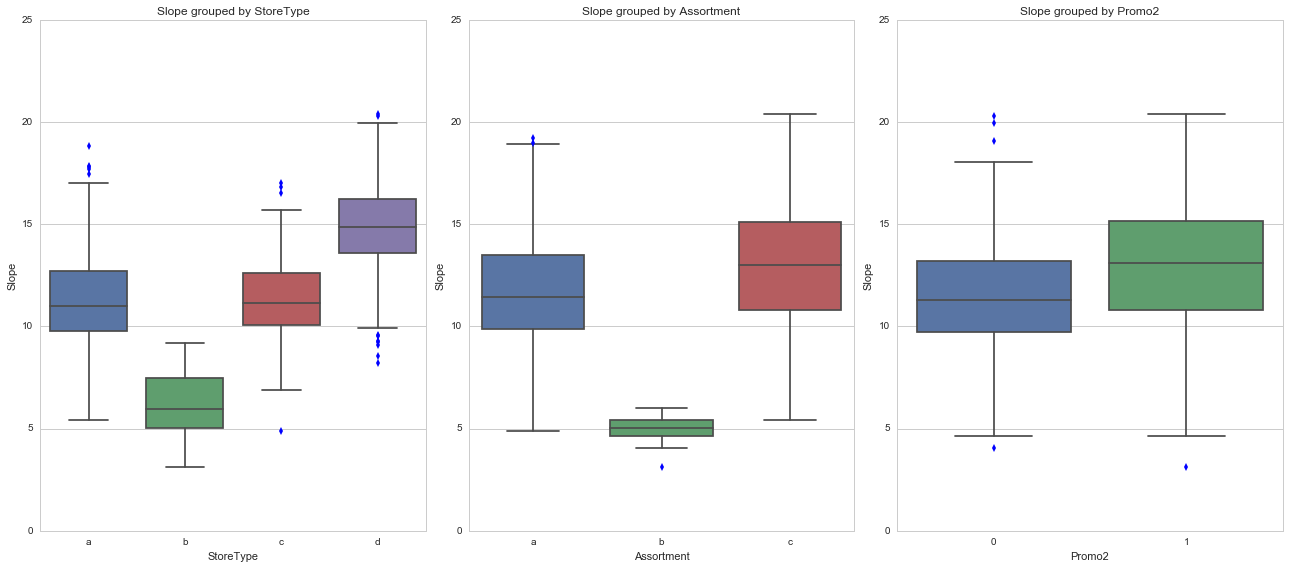

In [15]:

fig, ax_list = plt.subplots(1,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(store_data2,'Slope', 'StoreType', ax_list[0])
BoxPlotGroupBy(store_data2,'Slope', 'Assortment', ax_list[1])
BoxPlotGroupBy(store_data2,'Slope', 'Promo2', ax_list[2])
fig.tight_layout()
plt.show()

# merge the new feature
SubSet=store_data2[['Store', 'Slope']]
test_data2=pd.merge(test_data2, SubSet, on='Store')
train_data2=pd.merge(train_data2, SubSet, on='Store')

# Assortment and store type can be combined into a new feature "store efficiency (StoreEff)" to capture the effect of type and assortment on Unit Customer sales.

['ca' 'aa' 'cc' 'ac' 'da' 'dc' 'ba' 'bb' 'bc']


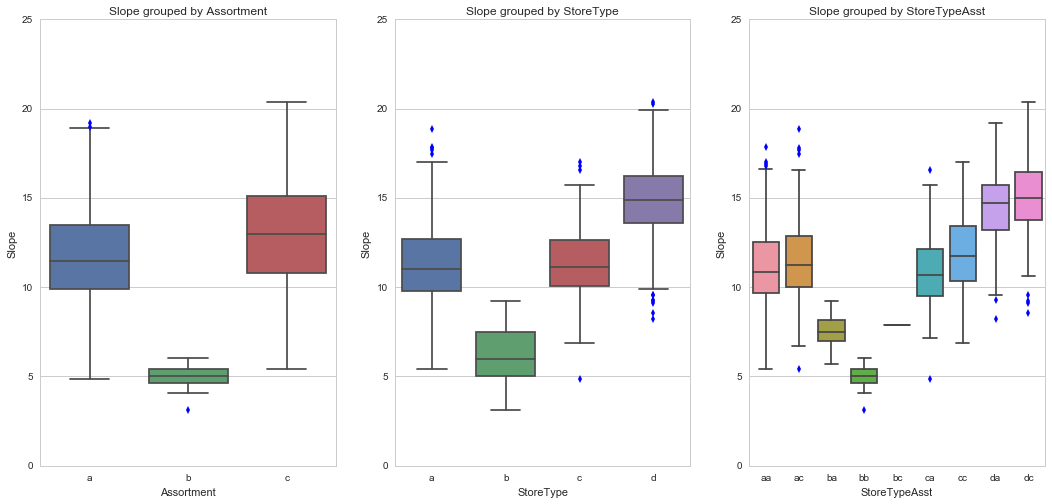

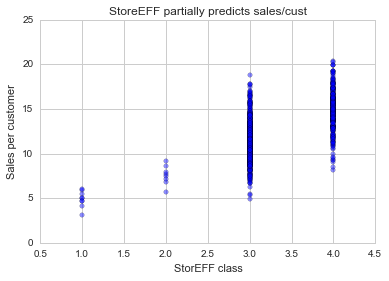

In [16]:
# combine store and assortment data into sales per customer (efficiency bins)
store_data2['StoreTypeAsst']=store_data2['StoreType'] + store_data2['Assortment']
print store_data2['StoreTypeAsst'].unique()

fig, ax_list = plt.subplots(1,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(store_data2,'Slope', 'Assortment', ax_list[0])
BoxPlotGroupBy(store_data2,'Slope', 'StoreType', ax_list[1])
BoxPlotGroupBy(store_data2,'Slope', 'StoreTypeAsst', ax_list[2])

# make a new contnuous variable "Sales Efficiency" (storeEff) 
# binning stores by how effective each store is at selling 
# bb < ba, bc < aa, ac, ca, cc
transform={'bb':1,'ba':2,'bc':2, 'aa':3, 'ca':3, 'ac':3,  'cc':3, 'da':4,'dc':4}
eff=store_data2.StoreTypeAsst
eff = [transform[eff[i]] for i in range(len(eff))]
store_data2['storeEff']=eff

#NEW FEATURE merge in the new features
SubS_St=store_data2[['Store', 'StoreTypeAsst',  'storeEff']]
train_data2=pd.merge(train_data2, SubS_St, on='Store', how='inner')
test_data2=pd.merge(test_data2, SubS_St, on='Store', how='inner')


plt.figure()
plt.scatter(store_data2.storeEff, store_data2.Slope, marker="o", alpha=.45)
plt.title ("StoreEFF partially predicts sales/cust")
plt.xlabel('StorEFF class')
plt.ylabel('Sales per customer')

# Does competition distance affect unit sales/cust? 
** Is there an interaction with store type? **

** It does appear that there is an effect of distance that disappears at 5000-10000 **

** this may have a stronger effect on b (blue) stores **


make a new feature to reflect the heterogenious effect of distance


/Users/GunnarK/anaconda/envs/MIDS_ML/lib/python2.7/site-packages/ipykernel/__main__.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


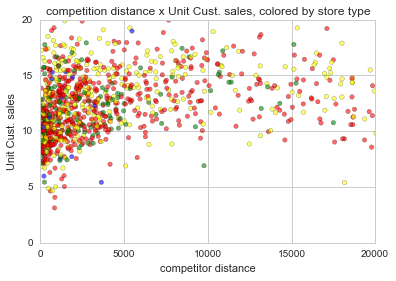

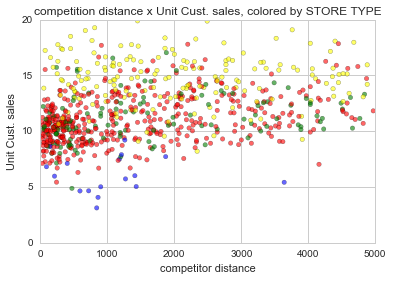

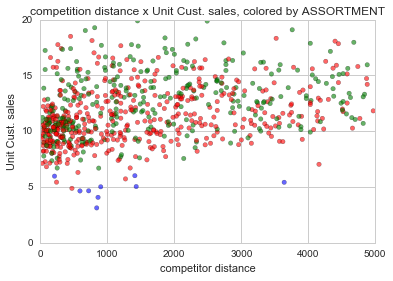

In [17]:
plt.figure()
y=store_data2.Slope
x=store_data2.CompetitionDistance

#recode strings as colors
transform = {"a": 'red', "b": 'blue', "c": 'green', "d": 'yellow'}
colors=store_data2.StoreType
colors = [transform[colors[i]] for i in range(len(colors))]

# TO DO: look a little deeper at the store type X dist interaction
# plot best fit lines; b type (blue) might be susceptable to competition
plt.title('competition distance x Unit Cust. sales, colored by store type')
plt.xlabel('competitor distance')
plt.ylabel('Unit Cust. sales')
plt.axis([0,20000, 0, 20])
plt.scatter(x,y, c=colors, marker="o", alpha=.6)


DistTH=5000
plt.figure()
subset=store_data2[store_data2.CompetitionDistance < DistTH]
subset=subset.reset_index()
y=subset.Slope
x=subset.CompetitionDistance

#recode strings as colors
transform = {"a": 'red', "b": 'blue', "c": 'green', "d": 'yellow'}
colors=subset.StoreType
colors = [transform[colors[i]] for i in range(len(colors))]

plt.title('competition distance x Unit Cust. sales, colored by STORE TYPE')
plt.xlabel('competitor distance')
plt.ylabel('Unit Cust. sales')
plt.axis([0,DistTH, 0, 20])
plt.scatter(x,y, c=colors, marker="o", alpha=.6)

## fixed version does not work as well
def AdjDistFIX(data, distTH):
    #Zero out distances further than the threshold
    #[data[x]['AdjDist']= 0, for x in train_data2 if train_data2.CompetitionDistance[X] > (MaxDist-distTH)]
    
    #reverse the distance (max becomes 0, min becomes max)
    MaxDist=np.max(data.CompetitionDistance)
    data['AdjDist']=np.max(data.CompetitionDistance)-data.CompetitionDistance
    for x in range(len(data)):   
        if data.AdjDist[x] < (np.max(data.CompetitionDistance)-distTH):
            #print data.CompetitionDistance[x]
            #print distTH
            #print data.CompetitionDistance[x] > distTH
            data.AdjDist[x] = 0 
    #subtract the threshold distance from the baseline
    data['AdjDist']=data.AdjDist-(np.max(data.CompetitionDistance)-distTH)
    return data  

##OLD,better 
def AdjDist(data, distTH):
    #reverse the distance (max becomes 0, min becomes max)
    MaxDist=np.max(data.CompetitionDistance)
    data['AdjDist']=np.max(data.CompetitionDistance)-data.CompetitionDistance
    
    #Zero out distances further than the threshold
    for x in range(len(data)):
        if data.CompetitionDistance[x] > distTH:
            #print data.CompetitionDistance[x]
            #print distTH
            #print data.CompetitionDistance[x] > distTH
            data.AdjDist[x] = 0 
    data        
    return data 

print 'make a new feature to reflect the heterogenious effect of distance'

#NEW FEATURE
distTH=5000 
store_data2=AdjDistFIX(store_data2, distTH) 

#NEW FEATURE merge in the new features
SubS_St=store_data2[['Store', 'AdjDist']]
train_data2=pd.merge(train_data2, SubS_St, on='Store', how='inner')
test_data2=pd.merge(test_data2, SubS_St, on='Store', how='inner')

plt.figure()

# at a certain disance the competitor is too far
distTH=5000

subset2=store_data2[store_data2.CompetitionDistance < distTH]
subset2=subset2.reset_index()
y=subset2.Slope
x=subset2.CompetitionDistance

#recode strings as colors
transform = {"a": 'red', "b": 'blue', "c": 'green', "d": 'yellow'}
colors=subset2.Assortment
colors = [transform[colors[i]] for i in range(len(colors))]
plt.title('competition distance x Unit Cust. sales, colored by ASSORTMENT')
plt.xlabel('competitor distance')
plt.ylabel('Unit Cust. sales')
plt.axis([0, distTH, 0, 20])
plt.scatter(x,y, c=colors, marker="o", alpha=.6)


# We made an adjusted distance that (AdjDist) that zeros out after a threshold distance
 

# Stepping back to get overview of how the variables interact with sales shows a strong positive skew adding noise to most variables

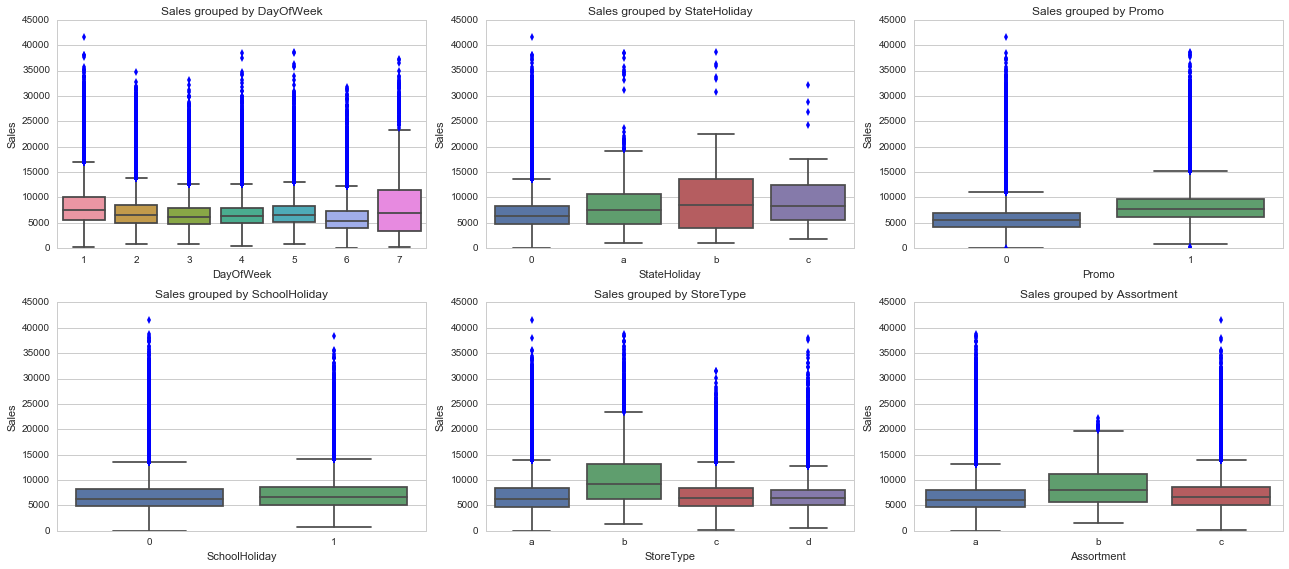

In [18]:
fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data2, 'Sales', 'DayOfWeek', ax_list[0])
BoxPlotGroupBy(train_data2,'Sales', 'StateHoliday', ax_list[1])
BoxPlotGroupBy(train_data2,'Sales', 'Promo', ax_list[2])
BoxPlotGroupBy(train_data2,'Sales', 'SchoolHoliday', ax_list[3])
BoxPlotGroupBy(train_data2,'Sales', 'StoreType', ax_list[4])
BoxPlotGroupBy(train_data2,'Sales', 'Assortment', ax_list[5])
fig.tight_layout()

plt.show()

# Add log sales to deal with postive skew

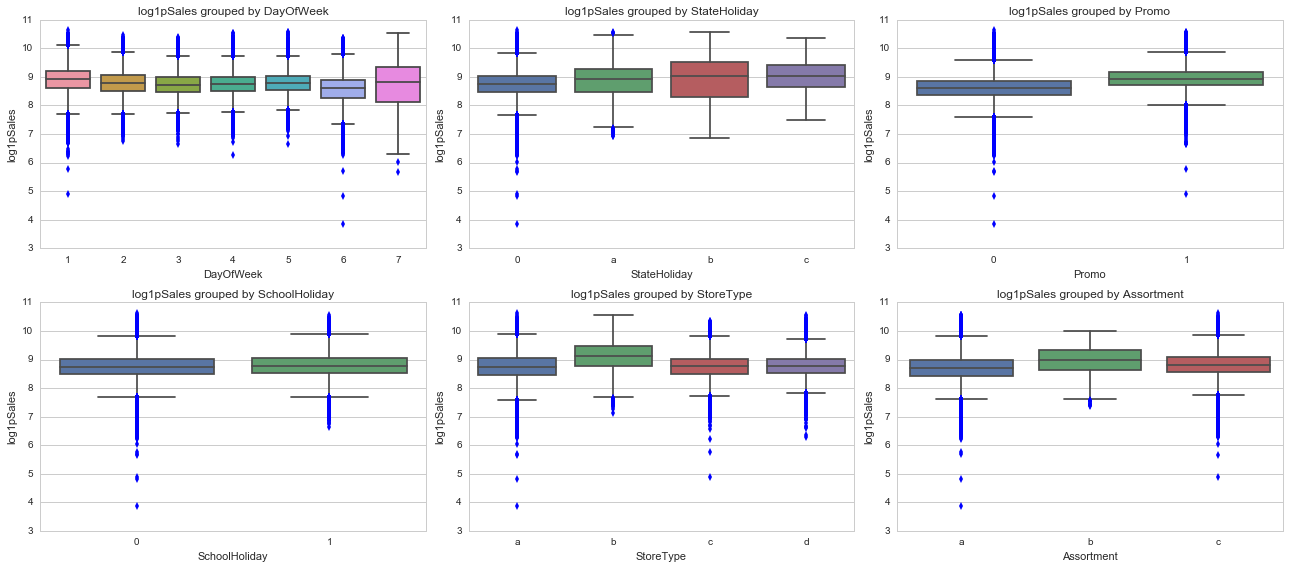

In [20]:
train_data2['log1pSales'] = np.log1p(train_data2['Sales'])

fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data2, 'log1pSales', 'DayOfWeek', ax_list[0])
BoxPlotGroupBy(train_data2,'log1pSales', 'StateHoliday', ax_list[1])
BoxPlotGroupBy(train_data2,'log1pSales', 'Promo', ax_list[2])
BoxPlotGroupBy(train_data2,'log1pSales', 'SchoolHoliday', ax_list[3])
BoxPlotGroupBy(train_data2,'log1pSales', 'StoreType', ax_list[4])
BoxPlotGroupBy(train_data2,'log1pSales', 'Assortment', ax_list[5])
fig.tight_layout()

plt.show()


# there are still a lot of outliers but the skew is reduced

# The sales data per month appears to be constant except in a few key months. 

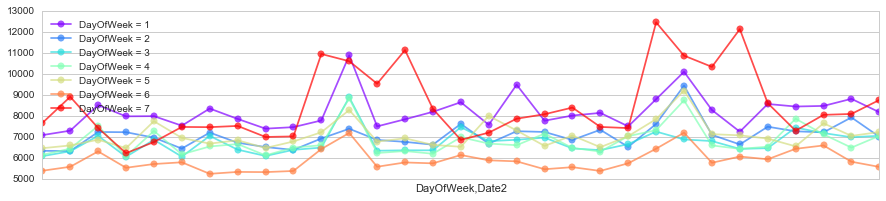

In [21]:
PlotAvgSalesByGroup('DayOfWeek')

# add a new feature ('MonthBin') to reduce the month levels to a few bins

month
1     6564.298651
2     6589.494012
3     6976.817749
4     7046.659509
5     7106.808038
6     7001.402127
7     6953.575827
8     6649.229053
9     6547.469104
10    6602.967255
11    7188.554250
12    8608.956661
Name: Sales, dtype: float64
CUSTOMER NUMBER rather than customer unit sales appears
to be contributing most to the positively skewed tail.


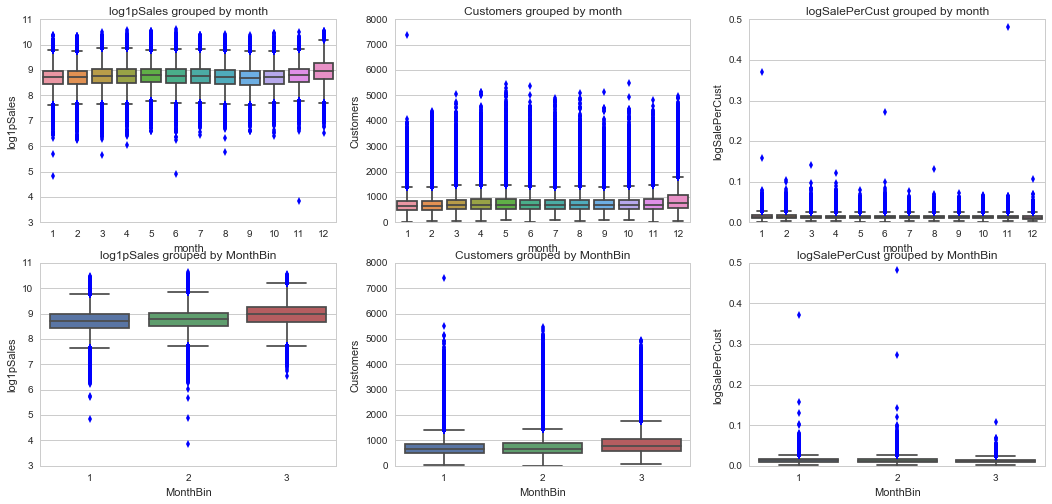

In [24]:
import scipy.stats as ss

TnMonth=train_data2.groupby('month')
print TnMonth['Sales'].mean()

# Bin months in an ordinal variable MonthBin

#BIN 1: range 6564-6649 (1,9,2,8,10)
#1     6564.298651
#9     6547.469104
#2     6589.494012
#8     6649.229053
#10    6602.967255

#BIN 2: range 6953-7188
#3     6976.817749
#7     6953.575827
#6     7001.402127
#4     7046.659509
#5     7106.808038
#11    7188.554250

#BIN 3: range 8608
#12    8608.956661

print 'CUSTOMER NUMBER rather than customer unit sales appears' 
print 'to be contributing most to the positively skewed tail.'

# NEW FEATURE add the new customer centric variables
# this is like the storeEff but is broken down for every training measurement
train_data2['SalePerCust']=train_data2.Sales/train_data2.Customers
train_data2['logSalePerCust']=train_data2.log1pSales/train_data2.Customers


# NEW FEATURE - MonthBin
# make the variable
train_data2['MonthBin']=train_data2.month
test_data2['MonthBin']=train_data2.month
transform={1:1, 2:1, 8:1, 9:1, 10:1, 3:2, 7:2, 6:2, 4:2, 5:2, 11:2, 12:3}
#MonBin=train_data2.month
train_data2.MonthBin = [transform[train_data2.MonthBin[i]] for i in range(len(train_data2.MonthBin))]
test_data2.MonthBin = [transform[test_data2.MonthBin[i]] for i in range(len(test_data2.MonthBin))]
#store_data2['MonthBin']=np.empty(len(store_data2))

fig, ax_list = plt.subplots(2,3, figsize=(18,8))
ax_list = ax_list.ravel()

BoxPlotGroupBy(train_data2, 'log1pSales', 'month', ax_list[0])
BoxPlotGroupBy(train_data2, 'Customers', 'month', ax_list[1])
BoxPlotGroupBy(train_data2, 'logSalePerCust', 'month', ax_list[2])

BoxPlotGroupBy(train_data2, 'log1pSales', 'MonthBin', ax_list[3])
BoxPlotGroupBy(train_data2, 'Customers', 'MonthBin', ax_list[4])
BoxPlotGroupBy(train_data2, 'logSalePerCust', 'MonthBin', ax_list[5])

# MonthBin appears to REDUCE heterogenity when viewed as sales/customer.

CUSTOMER NUMBER rather than customer unit sales appears to be contributing most to the positively skewed tail.

NOTE THE  heterogenity of variance that is captured by monthbin for sales/customer
it appears that somthing is increasing noise in sales/customer in bin 1 months

# promo appears to be an important feature

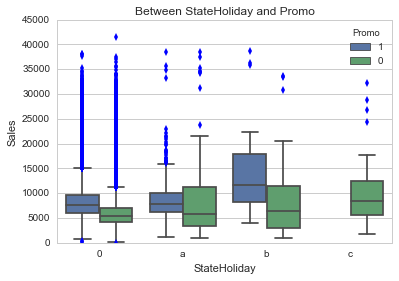

In [25]:
y = 'Sales'
ax = sns.boxplot(x = 'StateHoliday', y = 'Sales', hue = 'Promo', data = train_data)
ax.set_title("Between StateHoliday and Promo")

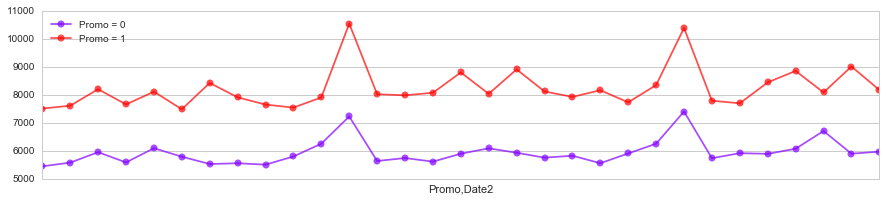

In [26]:
PlotAvgSalesByGroup('Promo')
# promo seems to interact with month a little 

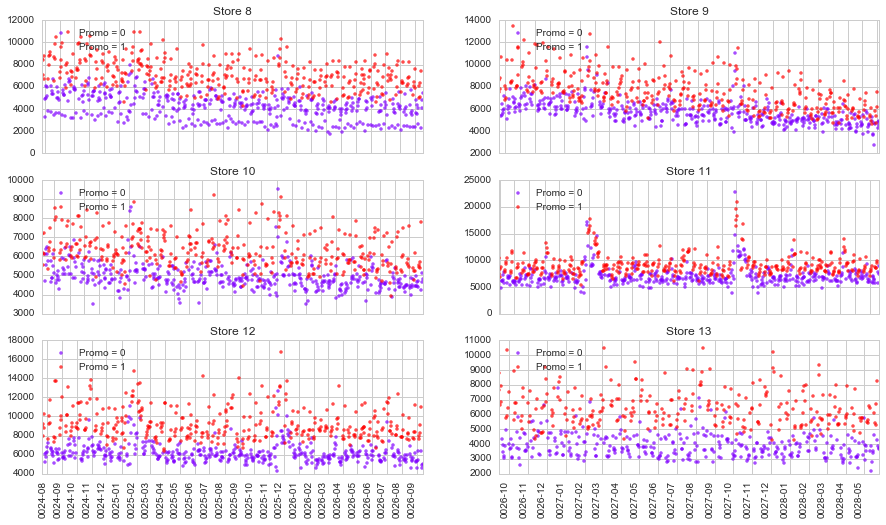

In [27]:
PlotAvgSalesByGroup('Promo', storeId=range(8,14), dim=[3,2], marker='.',daily=True, linestyle='None', alpha=0.7)

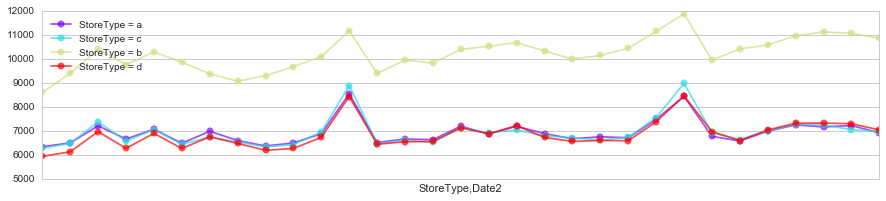

In [28]:
PlotAvgSalesByGroup('StoreType')

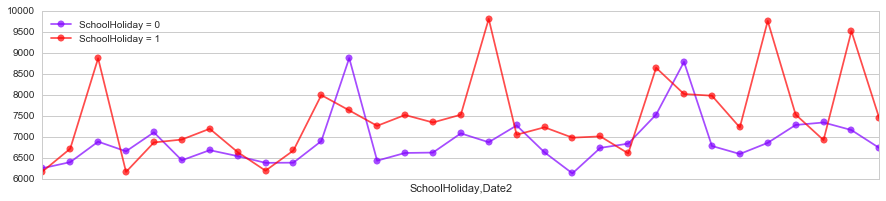

In [29]:
PlotAvgSalesByGroup('SchoolHoliday')
# school holiday is complex, but GENERALLY adds to sales 

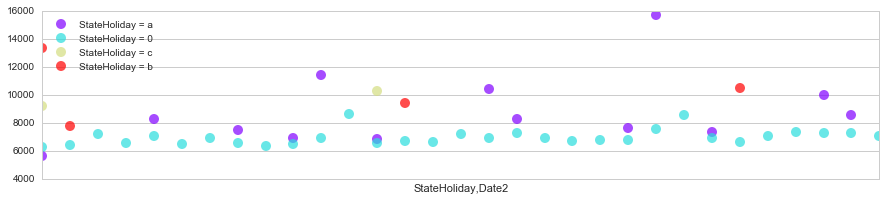

In [30]:
PlotAvgSalesByGroup('StateHoliday', linestyle='None', marker='o', markersize=10, alpha=0.7)

In [63]:
# MERGE
#For each store, find its first opening day and merge it into store_df

#train_by_Store_data = train_data.groupby('Store')
#storeOpenDays = train_by_Store_data['Date'].min()
#pd.unique(storeOpenDays)
#storeOpenDays[storeOpenDays != np.datetime64('2013-01-02')]

#d = pd.DataFrame(storeOpenDays)
#d = d.rename(columns = {'Date':'OpenDay'})
#store_data = pd.merge(store_data, d, left_on = 'Store', right_index = True) 


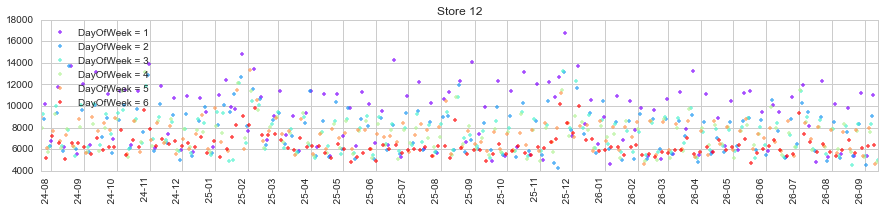

In [65]:
PlotAvgSalesByGroup('DayOfWeek', storeId=12, marker='.',daily=True, linestyle='None')

# Some ideas for future development


** Integrate store-specific customer traffic index **

** Since there is non-overlap between days, use **

** cumulative days and SVM to make a daily traffic prediction for each store **

### Look more at  relationship between store attributes and average monthly sales?###

**this is interesting since type b store is the least efficient at making sales, but has the most sales.**


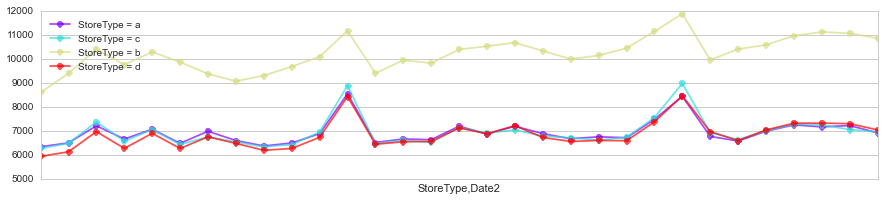

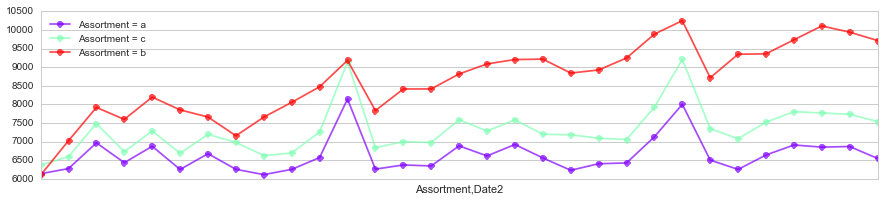

In [66]:
PlotAvgSalesByGroup('StoreType', alpha=0.7)
PlotAvgSalesByGroup('Assortment')
#PlotAvgSalesByGroup('StoreTypeAsst')

In [67]:
#I see a temporally increasing trend in store type b and assortment b somewhat assortment c (But not the others) have a
#how do we capture this variation, baseline increase for each class?

#regress assortment x date and use the correlation coefficient to get the temporal effect..
#change date to 1-days from opening 2-month (christmas season or not) 3-total days 

# 2 -  A summary of our model engineering


| model | description |features | Changes | Results |
| :------------ |:---------------:| :-----:|:---------------:| :-----:|
| OLS Model Per Store in R | Initial Submission| DayOfWeek + Open + Promo + StateHoliday + SchoolHoliday | baseline | RMSE =0.83, 15 from bottom|
| Various models + Cross Validation  | model exploration |Stores + DayOfWeek + Open + Promo + StateHoliday + SchoolHoliday | logSales, dummy variables in sparse array, changed model included store as a feature | RandomForestRegressor with 50 levels, 2 folds was the best, submitted score = 0.15221, **Took hours to days**|
| X gradient boost (XGB)| Feature exploration to improve on reported excellent performance | various features,  external vs internal evaluation | converged on slightly improved performance | best submitted RMSE =0.13704 **train time reduced (~10 min)** |
| SVR, nuSVR, Random Forest Regressor and Kernel Ridge | more complex features, regression at store level | Added: Month of Promo2, dropped (StateHoliday + SchoolHoliday + StoreType + Assortment) | Multiple regressors at store level, dropped variables | NuSVM, submitted **score = 0.11413**, training time ~2 minutes|
| Stack models | Stack 6 models (1 SVM model + 2 XGB models + 3 RF models) | full varaible set plus ratio1 and ratio2  | No improvement **model overfit** | train error = 0.074728 for baseline error for stacked=  0.074210|

In [ ]:
#scale the data

# 3-show the models that we tried 
- i'll remove our names in the final book but lets keep it separate for clarity now
- Note that the modified dataframes are train_data2

In [327]:
### Setup, functions and packages ###

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import xgboost as xgb
import operator
import matplotlib
matplotlib.use("Agg") #Needed to save figures
import matplotlib.pyplot as plt


 **3a-Ron's attemps**

## Initial Submission - OLS Model Per Store in R ##
The initial submission to get the team registered in the competition was a simple OLS approach using a single OLS model per store. It was written in R to get something out quickly. This approach performed poorly with a ranking just 15 or so from the bottom and a RMSE of 0.83.

```
train <- read.csv("~/Development/kaggle/rossman/data/train.csv")
train$Date <- as.Date(train$Date, format="%Y-%m-%d")
models <- vector(mode="list", length=2000)

first <- min(train$Store)
last <- max(train$Store)

# Sanity check on a simple OLS regression
lm1 <- lm(Sales ~ DayOfWeek + Open + Promo + StateHoliday + SchoolHoliday, data=subset(train, Store==1))
summary(lm1)

# Create an OLS model per store
for (store in first:last)
{
	models[[store]] <- lm(Sales ~ DayOfWeek + Open + Promo + StateHoliday + SchoolHoliday, data=subset(train, Store==store), na.action=na.omit)
}

test <- read.csv('~/Development/kaggle/rossman/data/test.csv',na.strings=c(""))
str(test)
test$Date <- as.Date(test$Date, format="%Y-%m-%d")

# Clean up NA items
na_df <- subset(test, is.na(test$Open))

# set Open to 1 if StateHoliday = 0, SchoolHoliday=0 and DayofWeek != 7
test$Open <- ifelse(is.na(test$Open) & test$StateHoliday != 0 & test$SchoolHoliday != 0 & test$DayOfWeek != 7, 1, 0) 

df <- data.frame(Id = numeric(max(test$Id)), Sales = numeric(max(test$Id)))

for (i in min(test$Id):max(test$Id))
{
	df$Id[i] <- i
	df$Sales[i] <- predict(models[[test$Store[i]]], newdata=test[i,])
}
# Write out the predictions to submit
write.csv(df, file='~/Development/kaggle/rossman/data/predict.csv', row.names=FALSE)
```

## Early Model Analysis - Cross Validation with Categorical Features ##
We experimented early on with a variety of models to see what the initial submission results would look like. These models are only against the train data set and do not include the store attribute data.

In [25]:
import csv
import datetime
from sklearn import preprocessing
import numpy as np
from scipy import sparse
from sklearn.cross_validation import KFold
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor

import time

In [26]:
def load(file):
    #open file
    inF = open(file,'rb')
    rdr = csv.reader(inF,delimiter=',')

    #read column names
    cols = rdr.next()
    print cols

    #extract data
    dat = []
    for l in rdr:
        dat.append(l)
    return dat

dat = load('train.csv')
test = load('test.csv')

['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
['Id', 'Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']


In [27]:
#extract target var
Y = np.array([float(i[3]) for i in dat])

#drop sales,customers variables as not in test set
dat = [dat[i][:3] + dat[i][5:] for i in range(len(dat))]

#drop id from test set
test = [test[i][1:] for i in range(len(test))]

In [28]:
#convert dates to dt
for i in range(len(dat)):
    d = datetime.datetime.strptime(dat[i][2],'%Y-%m-%d')
    dat[i] = dat[i][:2] + dat[i][3:] + [str(d.year),str(d.month),str(d.day)]

for i in range(len(test)):
    d = datetime.datetime.strptime(test[i][2],'%Y-%m-%d')
    test[i] = test[i][:2] + test[i][3:] + [str(d.year),str(d.month),str(d.day)]

In [29]:
# encode all of the categories
# encode string to int
le1,le2,le3,le4,le5,le6,le7,le8,le9 = preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder(),preprocessing.LabelEncoder()
le1.fit([i[0] for i in dat])
le2.fit([i[1] for i in dat])
le3.fit([i[2] for i in dat])
le4.fit([i[3] for i in dat])
le5.fit([i[4] for i in dat])
le6.fit([i[5] for i in dat])
le7.fit([i[6] for i in dat])
le8.fit([i[7] for i in dat])
le9.fit([i[8] for i in dat])

print 'stores ',le1.classes_
print 'dow ',le2.classes_
print 'Open ',le3.classes_
print 'Promo ',le4.classes_
print 'StateHoliday ',le5.classes_
print 'SchoolHoliday ',le6.classes_

#transform train data
X_cat1 = le1.transform([i[0] for i in dat])
X_cat2 = le2.transform([i[1] for i in dat])
X_cat3 = le3.transform([i[2] for i in dat])
X_cat4 = le4.transform([i[3] for i in dat])
X_cat5 = le5.transform([i[4] for i in dat])
X_cat6 = le6.transform([i[5] for i in dat])
X_cat7 = le7.transform([i[6] for i in dat])
X_cat8 = le8.transform([i[7] for i in dat])
X_cat9 = le9.transform([i[8] for i in dat])
X_cat = [[X_cat1[i],X_cat2[i],X_cat3[i],X_cat4[i],X_cat5[i],X_cat6[i],X_cat7[i],X_cat8[i],X_cat9[i]] for i in range(len(X_cat1))]

#fix up test data i[2] contains the 'open' variable which in the test set has some unknown values
#here we assume if open is unknown then the shop is open
for i in test:
    if i[2]=='':
        i[2]='1'

#transform test data
test_cat1 = le1.transform([i[0] for i in test])
test_cat2 = le2.transform([i[1] for i in test])
test_cat3 = le3.transform([i[2] for i in test])
test_cat4 = le4.transform([i[3] for i in test])
test_cat5 = le5.transform([i[4] for i in test])
test_cat6 = le6.transform([i[5] for i in test])
test_cat7 = le7.transform([i[6] for i in test])
test_cat8 = le8.transform([i[7] for i in test])
test_cat9 = le9.transform([i[8] for i in test])
test_cat = [[test_cat1[i],test_cat2[i],test_cat3[i],test_cat4[i],test_cat5[i],test_cat6[i],test_cat7[i],test_cat8[i],test_cat9[i]] for i in range(len(test_cat1))]

stores  ['1' '10' '100' ..., '997' '998' '999']
dow  ['1' '2' '3' '4' '5' '6' '7']
Open  ['0' '1']
Promo  ['0' '1']
StateHoliday  ['0' 'a' 'b' 'c']
SchoolHoliday  ['0' '1']


In [30]:
#create dummy vars from the lables, making a sparse array
enc = preprocessing.OneHotEncoder(sparse=True)
enc.fit(X_cat)
X = enc.transform(X_cat)
test = enc.transform(test_cat)

In [31]:
#don't need stores with 0 sales
X = X[Y>0]
Y = Y[Y>0]
print np.shape(X)

(844338, 1178)


In [32]:
#log transform sales
print Y[:5]
Y = np.log(Y)
print Y[:5]

[  5263.   6064.   8314.  13995.   4822.]
[ 8.56845649  8.71012493  9.02569612  9.5464554   8.48094406]


#### Model Cross Validation

The RandomForestRegressor with 50 levels performed the best out of this set with an ultimate score of 0.15221 but required several hours just to perform a KFold cross-validation with only 2 folds.

**Don't run this unless you've got a lot of time...**

In [ ]:
#Do some cross val testing
kf = KFold(np.shape(X)[0], n_folds=2)
i=0
rmspe=[]
t1=time.time()
for train_index, test_index in kf:
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = Y[train_index], Y[test_index]
    #Scale Data
    #Scale X
    scaler = preprocessing.StandardScaler(with_mean=False)
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    #train model
    mod = RandomForestRegressor(n_estimators=50,n_jobs=-1) #very slow, especially on all data
    #mod = GradientBoostingRegressor(n_estimators=50)
    #mod = linear_model.SGDRegressor()#~500 error requires scaling
    #mod = naive_bayes.GaussianNB() #doesn't work with sparse
    mod.fit(X_train_scaled,Y_train)
    #make predictions
    preds = np.exp(mod.predict(X_test_scaled))
    Y_test = np.exp(Y_test)
    #score
    rmspe.append((np.mean(((preds-Y_test)/(Y_test+1))**2))**0.5)
    print i+1,rmspe[i]
    i=i+1
print 'Time =',int(time.time()-t1),'s'
print 'RMSPE avg =',np.mean(rmspe)

## XGBoost

The public forums for the Rossmann competition claim the best results using XGBoost, so we took a look at it to see what we could do with it.

The best score using this feature set was 0.13704

In [20]:
%matplotlib inline

import matplotlib.pyplot as plt
import graphviz
import csv
from datetime import datetime, timedelta
from sklearn.cross_validation import KFold, train_test_split
from dateutil.relativedelta import *
from sklearn import preprocessing
import numpy as np
from scipy import sparse
import pandas as pd
import xgboost as xgb
import time

In [3]:
# Set the data types ahead of time, especially the datetime column for Date

dtypes = {"Date": datetime, "StateHoliday": np.dtype(str), "SchoolHoliday": np.dtype(int)}

store_dtypes = {"CompetitionSinceYear": np.dtype(int), "CompetitionSinceMonth": np.dtype(int), 
                "Promo2SinceYear": np.dtype(int), "Promo2SinceWeek": np.dtype(int)}
data = pd.read_csv('train.csv', dtype=dtypes, parse_dates=[2])
stores = pd.read_csv('store.csv')

test = pd.read_csv('test.csv', dtype=dtypes, parse_dates=[3])

In [4]:
# remove rows with sales of 0
data = data[data.Sales > 0]

# extract sales to separate Series
# sales = data[['Store','Sales']]

# remove Sales and Customers columns
# data.drop(['Sales','Customers'], axis=1, inplace=True)

# check Open column and set to open if NaN
data.Open.fillna(1, inplace=True)

In [5]:
# recode StateHoliday as dummy variable
def stateHoliday_asDummy(df):
    sh = pd.get_dummies(df['StateHoliday'])

    sh.rename(columns={'0':'noHoliday','a':'PublicHoliday'}, inplace=True)
    sh[['noHoliday','PublicHoliday']] = sh[['noHoliday','PublicHoliday']].astype(int)
    try:
        sh.rename(columns={'b':'EasterHoliday','c':'XmasHoliday'}, inplace=True)
        sh[['EasterHoliday','XmasHoliday']] = sh[['EasterHoliday','XmasHoliday']].astype(int)
    except:
        pass

    df = pd.concat([df,sh], axis=1)
    return df

# recode SchoolHoliday as binary instead of categorical
def schoolHoliday_asDummy(df):
    df.SchoolHoliday = df.SchoolHoliday.apply(int)
    return df

def recodeCategorical_asInt(df, fn, newfn):
    df[newfn] = pd.Categorical.from_array(df[fn]).codes
    return df

# recode StoreType and Assortment as dummy variables
def storeType_asDummy(df):
    st = pd.get_dummies(df['StoreType'])    
    st.rename(columns={'a':'StoreTypeA','b':'StoreTypeB','c':'StoreTypeC','d':'StoreTypeD'}, inplace=True)
    df = pd.concat([df,st], axis=1)    
    df[['StoreTypeA','StoreTypeB','StoreTypeC','StoreTypeD']] = df[['StoreTypeA','StoreTypeB','StoreTypeC','StoreTypeD']].astype(int)
    return df
    
def assortment_asDummy(df):
    ass = pd.get_dummies(df['Assortment'])
    ass.rename(columns={'a':'BasicAssortment','b':'ExtraAssortment','c':'ExtendedAssortment'}, inplace=True)
    df = pd.concat([df,ass], axis=1)
    df[['BasicAssortment','ExtraAssortment','ExtendedAssortment']] = df[['BasicAssortment','ExtraAssortment','ExtendedAssortment']].astype(int)
    return df

# Convert PromoInterval to dummy variable
def promoInterval_asDummy(df):
    pi = pd.get_dummies(df['PromoInterval'])
    pi.rename(columns={'Feb,May,Aug,Nov':'PromoIntFebMayAugNov','Jan,Apr,Jul,Oct':'PromoIntJanAprJulOct',
                       'Mar,Jun,Sept,Dec':'PromoIntMarJunSeptDec','None':'PromoIntNone'}, inplace=True)
    df = pd.concat([df,pi], axis=1)
    df[['PromoIntFebMayAugNov','PromoIntJanAprJulOct','PromoIntMarJunSeptDec','PromoIntNone']] = \
        df[['PromoIntFebMayAugNov','PromoIntJanAprJulOct','PromoIntMarJunSeptDec','PromoIntNone']].astype(int)
    return df


def monthsPromo(x):
    months = 0
    if x.Promo2SinceYear > 0:
        d1s = str(int(x.Promo2SinceYear)) + '-' + str(int(x.Promo2SinceWeek))
        d1 = datetime.strptime(d1s + '-1', "%Y-%W-%w")
        months = (x.Date.year - d1.year) * 12 + x.Date.month - d1.month
        if months < 0:
            months = 0
    return months

def weeksPromo(x):
    weeks = 0
    if x.Promo2SinceYear > 0:
        d1s = str(int(x.Promo2SinceYear)) + '-' + str(int(x.Promo2SinceWeek))
        d1 = datetime.strptime(d1s + '-1', "%Y-%W-%w")
        m1 = (d1 - timedelta(days=d1.weekday()))
        m2 = (x.Date - timedelta(days=x.Date.weekday()))
        weeks = (m2 - m1).days / 7
        if weeks < 0:
            weeks = 0
    return weeks

def monthsComp(x):
    months = 0
    if x.CompetitionOpenSinceYear > 0:
        d1s = str(int(x.CompetitionOpenSinceYear)) + '-' + str(int(x.CompetitionOpenSinceMonth))
        d1 = datetime.strptime(d1s, "%Y-%m")
        r = relativedelta(x.Date,d1)
        months = r.years*12 + r.months
        if months < 0:
            months = 0
    return months

def calculateCompPromoFeatures(df):
    # Calculate the PromoWeeks and CompetitionMonths as single Series
    df['Promo2SinceWeeks'] = df.apply(weeksPromo, axis=1)
    df['Promo2SinceMonths'] = df.apply(monthsPromo, axis=1)
    df['CompetitionOpenSinceMonths'] = df.apply(monthsComp, axis=1)
    return df

#### Categorical vs. dummy variables

Calculate the features in different ways. We can use masking to pull the features we want when we train a model.

In [6]:
# Dummy variable approach
data = stateHoliday_asDummy(data)
data = schoolHoliday_asDummy(data)

# Categorical variable approach
data = recodeCategorical_asInt(data, 'SchoolHoliday', 'SchoolHolidayVal')
data = recodeCategorical_asInt(data, 'StateHoliday', 'StateHolidayVal')

In [7]:
# find NaN values in test data
#test.isnull().sum().sum()  # indicates 11 missing values
# test.Open.isnull().sum()  # they are all in the Open column
test.Open.fillna(1, inplace=True)
test.Open = test.Open.astype(int)

In [8]:
test = stateHoliday_asDummy(test)
test = schoolHoliday_asDummy(test)

test = recodeCategorical_asInt(test, 'StateHoliday', 'StateHolidayVal')
test = recodeCategorical_asInt(test, 'SchoolHoliday', 'SchoolHolidayVal')

In [9]:
# Clean up NaN values

# Set competition distance to 0 if NaN
stores.CompetitionDistance.fillna(0, inplace=True)

# Set CompetitionOpenSince values to 0 if NaN
stores.CompetitionOpenSinceMonth.fillna(0, inplace=True)
stores.CompetitionOpenSinceYear.fillna(0, inplace=True)

# Set Promo2Since values to 0 if NaN
stores.Promo2SinceWeek.fillna(0, inplace=True)
stores.Promo2SinceYear.fillna(0, inplace=True)

# Set PromoInterval value to the string 'None' if NaN
stores.PromoInterval.fillna('None', inplace=True)

In [10]:
#Dummy variables
stores = storeType_asDummy(stores)
stores = assortment_asDummy(stores)
stores = promoInterval_asDummy(stores)

# Categorical variables
stores = recodeCategorical_asInt(stores, 'StoreType', 'StoreTypeVal')
stores = recodeCategorical_asInt(stores, 'Assortment', 'AssortmentVal')
stores = recodeCategorical_asInt(stores, 'PromoInterval', 'PromoIntervalVal')

In [11]:
# perform a left outer join of the data and stores dataframes
all_data = pd.merge(data, stores, on='Store', how='left')

# same for the test data
all_test = pd.merge(test, stores, on='Store', how='left')

####Engineered Features
- calculate the number of months that the competition has been open, if any
- calculate the number of months that the store has participated in promo
- convert the date into day, month, year components
- convert the date into day of year component

All features are in the same dataframe. Features not needed downstream are masked out of the dataframe

In [12]:

# Now that we have the observation date combined with store metadata, we can recompute 
# the promosince... and competitionsince... year/week values as weeks before observation date

# This takes a really long time to execute...
all_data = calculateCompPromoFeatures(all_data)
all_test = calculateCompPromoFeatures(all_test)

In [13]:
all_data['day'] = all_data.Date.dt.day
all_data['month'] = all_data.Date.dt.month
all_data['year'] = all_data.Date.dt.year

all_test['day'] = all_test.Date.dt.day
all_test['month'] = all_test.Date.dt.month
all_test['year'] = all_test.Date.dt.year

In [14]:
# Calculate Day of Year from Date
all_data['DayOfYear'] = all_data.Date.dt.dayofyear
all_test['DayOfYear'] = all_test.Date.dt.dayofyear

In [36]:
# Construct feature list for the features we want to include in the models
feature_list_1 = ['Store','DayOfWeek','DayOfYear', 'CompetitionDistance', 'CompetitionOpenSinceMonths',
                'Promo', 'Promo2', 'Promo2SinceWeeks', 'noHoliday','PublicHoliday','EasterHoliday','XmasHoliday'
                'StoreTypeA', 'StoreTypeB', 'StoreTypeC', 'StoreTypeD', 'BasicAssortment', 'ExtraAssortment',
                'ExtendedAssortment', 'PromoIntNone', 'PromoIntFebMayAugNov', 'PromoIntJanAprJulOct',
                'PromoIntMarJunSeptDec']

feature_list_2 = ['Store','DayOfWeek','DayOfYear', 'CompetitionDistance', 'CompetitionOpenSinceMonths',
                'Promo', 'Promo2', 'Promo2SinceMonths', 'SchoolHolidayVal','StateHolidayVal',
                'StoreTypeVal', 'AssortmentVal', 'PromoIntervalVal']


feature_list_3 = ['Store','DayOfWeek','day', 'month', 'year', 'CompetitionDistance', 'CompetitionOpenSinceMonths',
                'Promo', 'Promo2', 'Promo2SinceMonths', 'SchoolHolidayVal','StateHolidayVal',
                'StoreTypeVal', 'AssortmentVal', 'PromoIntervalVal']

#### XBoost Parameters and evaluation functions

From the xgboost source code it looks like the custom feval function is passed two parameters: y_hat and y
where the y is a DMatrix object and the Y-hat the output of the prediction for that Y value.
The return is supposed to be a (string, value) tuple https://github.com/dmlc/xgboost/blob/master/python-package/xgboost/core.py

Also, how to use this function was not very clear but this example gives a clue:
https://github.com/dmlc/xgboost/blob/master/demo/guide-python/cross_validation.py

In [38]:
def rmspe(y_hat, dmat):
    # we need to reverse the log(Y)
    y = np.exp(dmat.get_label())
    return "rmspe", np.sqrt(np.mean(((np.exp(y_hat)-y)/(y-1))**2))

In [39]:
# Model parameters

# [546]	eval-rmspe:0.443694	train-rmspe:0.472175  (score 0.39930)
param_1 = {'max_depth':10, 'objective':'reg:linear', 'silent':1, 'eta': 0.5,
         'booster': 'gblinear', 'alpha' : 0.01, 'lambda' : 1}

# tree booster got to - 
# Stopping. Best iteration:
# [185]	eval-rmspe:0.111982	train-rmspe:0.016138 (Score of 0.13704)
param_2 = {'max_depth':20, 'objective':'reg:linear', 'silent':1, 'eta': 0.2,
         'booster': 'gbtree', 'alpha' : 0.001, 'lambda' : 1, 'gamma': 0}

# [164]	eval-rmspe:0.115576	train-rmspe:0.012887  (Score of 0.1398)
param_3 = {'max_depth':20, 'objective':'reg:linear', 'silent':1, 'eta': 0.2,
         'booster': 'gbtree', 'alpha' : 0.001, 'lambda' : 0.5, 'gamma': 0}

# [60]	eval-rmspe:0.119277	train-rmspe:0.002058
param_4 = {'max_depth':50, 'objective':'reg:linear', 'silent':1, 'eta': 0.2,
         'booster': 'gbtree', 'alpha' : 0.0001, 'lambda' : 0.5, 'gamma': 0, 'eval_metric':'rmse'}

# [60]	eval-rmspe:0.119277	train-rmspe:0.002058
param_5 = {'max_depth':50, 'objective':'reg:linear', 'silent':1, 'eta': 0.3,
         'booster': 'gbtree', 'alpha' : 0.001, 'lambda' : 1, 'gamma': 0.1}

param_6 = {'silent':1, 'booster': 'gblinear', 'objective':'reg:linear', 'alpha': 0.1, 'lambda': 0.01}

In [47]:
def xgfit(param, X, Y, internal_eval):

    # take the data from the all_data dataframe and sales dataframe
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state=42)

    # take the log of the Y values
    Ylog_train = np.log(Y_train)
    Ylog_test  = np.log(Y_test)
    
    # scale the data
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test, len(X_test))
    
    # xgboost generalized linear model
    dtrain = xgb.DMatrix(X_train_scaled, label=Ylog)
    dtest  = xgb.DMatrix(X_test_scaled,  label=Ylog_test)

    watchlist = [(dtest,'eval'), (dtrain,'train')]
    #watchlist = []

    num_round=1000
    if internal_eval:
        bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=150, verbose_eval=True)
    else:
        bst = xgb.train(param, dtrain, num_round, watchlist, early_stopping_rounds=150, verbose_eval=True, feval=rmspe)

#### Use external evaluation function

[163]	eval-rmspe:0.120292	train-rmspe:0.072652

In [44]:
xgfit(param_5, all_data[feature_list_3], all_data.Sales, internal_eval=False)

Will train until train error hasn't decreased in 150 rounds.
[0]	eval-rmspe:0.996858	train-rmspe:0.996857
[1]	eval-rmspe:0.981694	train-rmspe:0.981690
[2]	eval-rmspe:0.938946	train-rmspe:0.938950
[3]	eval-rmspe:0.858801	train-rmspe:0.858955
[4]	eval-rmspe:0.746475	train-rmspe:0.747119
[5]	eval-rmspe:0.620061	train-rmspe:0.621924
[6]	eval-rmspe:0.497309	train-rmspe:0.499702
[7]	eval-rmspe:0.390007	train-rmspe:0.393546
[8]	eval-rmspe:0.304970	train-rmspe:0.303154
[9]	eval-rmspe:0.241491	train-rmspe:0.234733
[10]	eval-rmspe:0.198994	train-rmspe:0.185454
[11]	eval-rmspe:0.170765	train-rmspe:0.150160
[12]	eval-rmspe:0.151190	train-rmspe:0.124605
[13]	eval-rmspe:0.141819	train-rmspe:0.109886
[14]	eval-rmspe:0.137131	train-rmspe:0.101161
[15]	eval-rmspe:0.130602	train-rmspe:0.091843
[16]	eval-rmspe:0.128959	train-rmspe:0.088261
[17]	eval-rmspe:0.127065	train-rmspe:0.085283
[18]	eval-rmspe:0.126199	train-rmspe:0.083512
[19]	eval-rmspe:0.125372	train-rmspe:0.082306
[20]	eval-rmspe:0.124338	trai

#### Use internal evaluation function

They converge in about the same place regardless of using the internal or external evaluation function

In [48]:
xgfit(param_5, all_data[feature_list_3], all_data.Sales, internal_eval=True)

Will train until train error hasn't decreased in 150 rounds.
[0]	eval-rmse:5.793333	train-rmse:5.793037
[1]	eval-rmse:4.061806	train-rmse:4.061370
[2]	eval-rmse:2.850458	train-rmse:2.849940
[3]	eval-rmse:2.003362	train-rmse:2.002872
[4]	eval-rmse:1.413055	train-rmse:1.412534
[5]	eval-rmse:1.000253	train-rmse:0.999536
[6]	eval-rmse:0.714765	train-rmse:0.713646
[7]	eval-rmse:0.512279	train-rmse:0.510537
[8]	eval-rmse:0.376222	train-rmse:0.372849
[9]	eval-rmse:0.283114	train-rmse:0.276961
[10]	eval-rmse:0.223176	train-rmse:0.212552
[11]	eval-rmse:0.183050	train-rmse:0.167778
[12]	eval-rmse:0.154486	train-rmse:0.135918
[13]	eval-rmse:0.139396	train-rmse:0.117448
[14]	eval-rmse:0.130775	train-rmse:0.106168
[15]	eval-rmse:0.120684	train-rmse:0.094852
[16]	eval-rmse:0.116905	train-rmse:0.090088
[17]	eval-rmse:0.113727	train-rmse:0.086299
[18]	eval-rmse:0.111754	train-rmse:0.083956
[19]	eval-rmse:0.110421	train-rmse:0.082393
[20]	eval-rmse:0.108835	train-rmse:0.080716
[21]	eval-rmse:0.108330	t

** 3b-patrick's attemps **

## Summary: ## 
 - One NuSVR model per store
    - Use a one model per store approach because logically each store is diffferent.
    - First tried a simple Linear Regression and Ridge Regression.
    - Then tried different non-Linear models: SVR, nuSVR, Random Forest Regressor and Kernel Ridge
    - nuSVR has the best performance
 - Use the last two months as the dev data
 - Dropping these features improves the score: StateHoliday, SchoolHoliday
 - Dropped these features because they're constant for a given store: StoreType, Assortment
 - Promo2:
    - Have tried two approaches:
        - (1) For each day, we have a binary feature specifying whether the store is on Promo2 or not.
        - (2) For the store as a whole, mark down which month has Promo2.
    - To my surprise, approach (2) actually works better.

LB score (before competition deadline): 0.11413

In [ ]:
def convertColToCategory_Patrick(data, colName, knownCategories):
    data.loc[:, colName] = data.loc[:, colName].astype('category', categories=knownCategories)

def transformData_Patrick(inputData):

    data = inputData.copy()

    data.loc[:, ('Month')] = data['Date'].dt.month
    data.loc[:, ('Year')] = data['Date'].dt.year
    
    # Convert categorical columns to category type
    convertColToCategory_Patrick(data, 'DayOfWeek', range(1, 8))
    convertColToCategory_Patrick(data, 'Month', range(1, 13))
    convertColToCategory_Patrick(data, 'Year', range(2013, 2016))
    convertColToCategory_Patrick(data, 'Promo', range(2))

    return pd.get_dummies(data)

def prepare_data_Patrick():
    train_df = pd.read_csv("train.csv", parse_dates = ['Date'])
    store_df = pd.read_csv("store.csv")
    
    # Got a warning about column 7 during import.
    # Fix it by change all 0 to '0'
    train_df.loc[train_df['StateHoliday'] == 0, 'StateHoliday'] = '0'

    # Keep only records where the store is open
    train_df = train_df[train_df['Open'] == 1]

    # Keep only records with non-zero sales
    train_df = train_df[train_df['Sales'] > 0]

    # Drop these columns, as they don't help with performance.
    train_df.drop('StateHoliday', inplace=True, axis=1)
    train_df.drop('SchoolHoliday', inplace=True, axis=1)

    # Each store has a binary feature for each month, specifying whether Promo2 is ON for that month
    for i in range(1,13):
        month = datetime.date(2008, i, 1).strftime('%b')
        store_df['Promo2_' + str(i)] = store_df['Promo2'] * store_df['PromoInterval'].apply(lambda x: month in str(x))

    store_cols = [i for i in store_df.columns.tolist() if 'Promo2_' in i]
    store_cols.append('Store')

    train_full_df = pd.merge(train_df, store_df.ix[:,store_cols], on='Store')
    train_data = transformData_Patrick(train_full_df)

    train_data.set_index('Date', inplace=True)
    train_data.sort_index(inplace=True)
    
    return train_data

In [22]:
x_drop_cols = ['Store', 'Sales', 'Customers', 'Open']

def trainModels_Patrick(train_data, n_cutoff_months, algo, store=None, **kwargs):

    all_y = []
    all_yhat = []
    all_rmspe = {}
    models = {}
    
    start = time.time()
    
    cols_to_drop = list(x_drop_cols)
    
    if store is not None:
        data = train_data[train_data['Store'] == store]
    else:
        data = train_data
    
    test_cutoff_date = data.index.max() - pd.DateOffset(months = n_cutoff_months)

    train_set = data[data.index <= test_cutoff_date]
    dev_set = data[data.index > test_cutoff_date]
    print "train_set size:", len(train_set)
    print "dev_set size:", len(dev_set)

    
    train_set_grouped = train_set.groupby('Store')
    dev_set_grouped = dev_set.groupby('Store')
    cols = None

    for group in train_set_grouped.groups.keys():        
        train_X = train_set_grouped.get_group(group).drop(cols_to_drop, axis=1, inplace=False)
        train_y = np.log(train_set_grouped.get_group(group)['Sales'])

        dev_X = dev_set_grouped.get_group(group).drop(cols_to_drop, axis=1, inplace=False)
        dev_y = np.log(dev_set_grouped.get_group(group)['Sales'])

        # One model per store
        if algo == 'lr':
            model = linear_model.LinearRegression(**kwargs)
        elif algo == 'ridge':
            model = linear_model.Ridge(**kwargs)
        elif algo == 'svr':
            model = svm.SVR(**kwargs)
        elif algo == 'nusvr':
            model = svm.NuSVR(**kwargs)
        elif algo == 'rfr':
            model = ensemble.RandomForestRegressor(**kwargs)
        elif algo == 'kr':
            model = kernel_ridge.KernelRidge(**kwargs)
            
        model.fit(X=train_X, y=train_y)
        models[group] = model
        yhat = model.predict(dev_X)

        all_y.extend(dev_y.tolist())
        all_yhat.extend(yhat.tolist())
        
        all_rmspe[group] = rmspe(np.exp(np.array(dev_y.tolist())), np.exp(yhat))
        
    print "Training model - dev data RMSPE=", rmspe(np.exp(np.array(all_y)), np.exp(np.array(all_yhat)))
    print "Model:\n", models[data.iloc[0]['Store']]
    
    print "Time taken: %.1fs" % (time.time() - start)
    
    return all_rmspe, models

def displayRmspes(rmspes):
    sorted_x = sorted(rmspes.items(), key=operator.itemgetter(1))
    print "Best 10:\n"
    print sorted_x[:10]
    print
    print "\bWorst 10:\n"
    print sorted_x[-10:]
    
def plotResult(train_data, models, store, rmspes, dateRange=None):
    fig, axis = plt.subplots(figsize=(15,4))
    data = train_data[train_data['Store'] == store]
    
    if dateRange is not None:
        head = pd.tslib.Timestamp(np.datetime64(dateRange[0]))
        tail = pd.tslib.Timestamp(np.datetime64(dateRange[1]))
        data = data[np.logical_and(data.index >= head, data.index <= tail)]        
    
    yhat = models[store].predict(data.drop(x_drop_cols, axis=1, inplace=False))
    axis.plot(data.index.tolist(), np.log(data['Sales']).tolist(), marker='.',
         color='b', linestyle='None', alpha=0.5)
    axis.plot(data.index.tolist(), yhat.tolist(), marker='.',
     color='r', linestyle='None', alpha=0.5)
    axis.set_title('Store = %s; rmspe = %f' % (str(store), rmspes[store]))

In [13]:
train_data_patrick = prepare_data_Patrick()

#### Try different models ####

In [14]:
rmspes, models = trainModels_Patrick(train_data_patrick, 2, 'lr', store=None)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.141207144887
Model:
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
Time taken: 10.6s


In [15]:
rmspes, models = trainModels_Patrick(train_data_patrick, 2, 'svr', store=None)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.128787214294
Model:
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)
Time taken: 50.2s


In [16]:
rmspes, models = trainModels_Patrick(train_data_patrick, 2, 'nusvr', store=None, cache_size=900, nu=0.8)

train_set size: 785727
dev_set size: 58611
Training model - dev data RMSPE= 0.126791703666
Model:
NuSVR(C=1.0, cache_size=900, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, nu=0.8, shrinking=True, tol=0.001, verbose=False)
Time taken: 117.1s


#### Perform some model prediction inspection ####

In [20]:
displayRmspes(rmspes)

Best 10:

[(974, 0.066575251553563336), (523, 0.067665716164997031), (783, 0.069702107525504681), (423, 0.070379823636023395), (1080, 0.07083914957418605), (562, 0.072060871436608345), (245, 0.072377612262845517), (260, 0.073779539848055825), (498, 0.074046834651123022), (613, 0.074508662199322326)]

Worst 10:

[(1039, 0.3066301857439423), (550, 0.32066377662593959), (711, 0.3386872723853448), (876, 0.35749741128836837), (286, 0.36000129265894348), (770, 0.36206801037223341), (782, 0.48332450783742814), (909, 0.56172182295427653), (415, 0.73839651222256186), (292, 0.73980893701236061)]


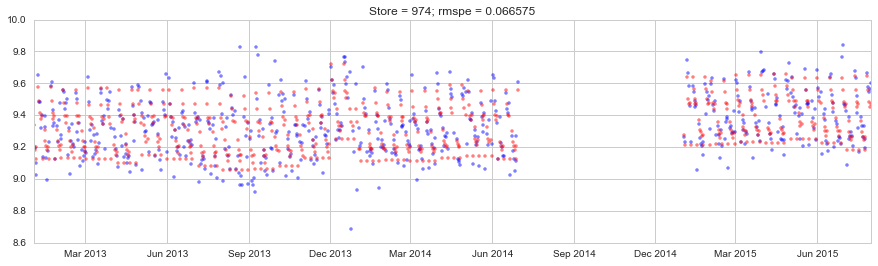

In [24]:
plotResult(train_data_patrick, models, 974, rmspes)

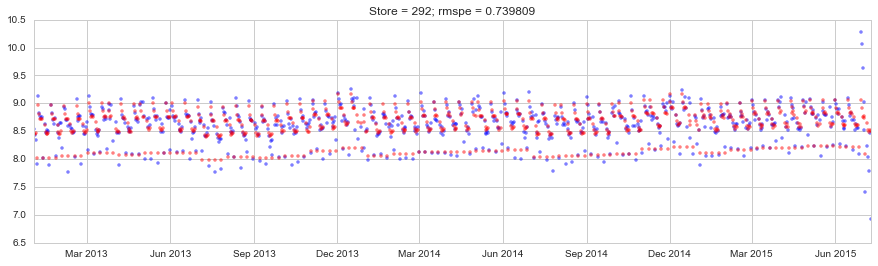

In [23]:
plotResult(train_data_patrick, models, 292, rmspes)

** 3c-Gunnar's attemps** 

In [458]:
## functions ####

'''
Based on https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
which was based on
Based on https://www.kaggle.com/justdoit/rossmann-store-sales/xgboost-in-python-with-rmspe/code
Public Score :  0.11389
Private Validation Score :  0.096959
'''

def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    for i, feat in enumerate(features):
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
    outfile.close()

def rmspe(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)


## Main script
## based on 

                                
# training the model script https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
def trainXGB(train, test, params, features, resultNm):
    start = time.time()
    num_boost_round = 300
    X_train, X_valid = train_test_split(train, test_size=0.012, random_state=10)
    Y_train, Y_valid = np.log1p(X_train.Sales), np.log1p(X_valid.Sales) 
    dtrain = xgb.DMatrix(X_train[features], Y_train)
    dvalid = xgb.DMatrix(X_valid[features], Y_valid)

    #>watchlist = [(dtrain, 'train'), (dvalid, 'eval')]
    gbm = xgb.train(params, dtrain, num_boost_round, evals=watchlist, \
      early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True) #

    print("Validating")
    yhat = gbm.predict(xgb.DMatrix(X_valid[features]))
    error = rmspe(X_valid.Sales.values, np.expm1(yhat))
    print('RMSPE: {:.6f}'.format(error))
    

    print("Make predictions on the test set")
    dtest = xgb.DMatrix(test[features])
    test_probs = gbm.predict(dtest)
    # Make Submission
    result = pd.DataFrame({"Id": test["Id"], 'Sales': np.expm1(test_probs)})
    resultNm="xgboost_" + resultNm + "subm.csv"
    result.to_csv(resultNm, index=False)
    end = time.time()
    print 'the prediction took ' + str((end-start)/60) + 'Mins'
    
# XGB feature importances
# Based on https://www.kaggle.com/mmueller/liberty-mutual-group-property-inspection-prediction/xgb-feature-importance-python/code
def feat_import(features, xgb):
    create_feature_map(features)
    importance = gbm.get_fscore(fmap='xgb.fmap')
    importance = sorted(importance.items(), key=operator.itemgetter(1))

    df = pd.DataFrame(importance, columns=['feature', 'fscore'])
    df['fscore'] = df['fscore'] / df['fscore'].sum()

    featp = df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 10))
    plt.title('XGBoost Feature Importance')
    plt.xlabel('relative importance')
    fig_featp = featp.get_figure()
    fig_featp.savefig('feature_importance_xgb.png', bbox_inches='tight', pad_inches=1)

# XGB runs - engineering distance to competition

In [424]:
#12_11_15 XGB

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }


###  Scale ####
train_data2.fillna(0, inplace=True)
test_data2.fillna(0, inplace=True)

train_scaled = train_data2
test_scaled = test_data2
train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])

trainXGB(train_scaled, test_scaled, params, features, 'x')


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996852	eval-rmspe:0.996852
[1]	train-rmspe:0.981639	eval-rmspe:0.981646
[2]	train-rmspe:0.938308	eval-rmspe:0.938339
[3]	train-rmspe:0.857394	eval-rmspe:0.857320
[4]	train-rmspe:0.744900	eval-rmspe:0.744280
[5]	train-rmspe:0.620698	eval-rmspe:0.618136
[6]	train-rmspe:0.504969	eval-rmspe:0.498341
[7]	train-rmspe:0.413052	eval-rmspe:0.399831
[8]	train-rmspe:0.349137	eval-rmspe:0.327090
[9]	train-rmspe:0.310920	eval-rmspe:0.279160
[10]	train-rmspe:0.294194	eval-rmspe:0.253610
[11]	train-rmspe:0.288044	eval-rmspe:0.240878
[12]	train-rmspe:0.286578	eval-rmspe:0.235744
[13]	train-rmspe:0.281502	eval-rmspe:0.232359
[14]	train-rmspe:0.276603	eval-rmspe:0.227774
[15]	train-rmspe:0.277468	eval-rmspe:0.227384
[16]	train-rmspe:0.278333	eval-rmspe:0.227583
[17]	train-rmspe:0.276187	eval-rmspe:0.224801
[18]	train-rmspe:0.274262	eval-rmspe:0.224242
[19]	train-rmspe:0.271150	eval-rmspe:0.220265
[20]	train-rmspe:0.269909	eval

Validating
RMSPE: 0.153434
Make predictions on the test set


[299]	train-rmspe:0.208304	eval-rmspe:0.153434


TypeError: cannot concatenate 'str' and 'float' objects

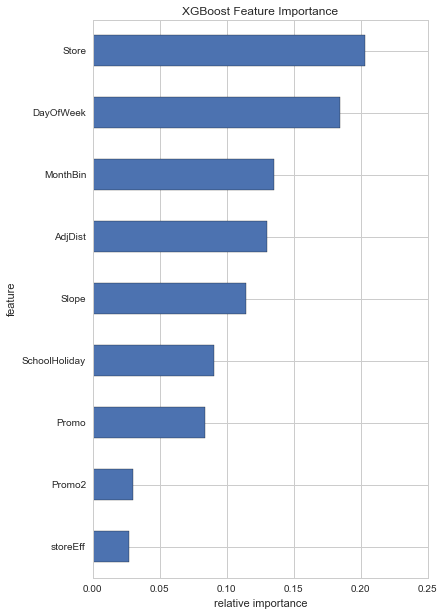

In [418]:
feat_import(features, xgb)

#RMSPE: 0.153434
# store (raw number) is the most important (.21)
# and store eff is the least (.025)
#slope seems to do pretty well (0.12)
# submitted, scored .13512

In [474]:
#12_11_15 redo XGB
# this was the best run so far, but I dont seem to be able to replicate it 
# here I am copy pasting the run.


#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }


###  Scale ####
train_data2.fillna(0, inplace=True)
test_data2.fillna(0, inplace=True)

train_scaled = train_data2
test_scaled = test_data2
train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])

trainXGB(train_scaled, test_scaled, params, features, 'x')

# the result does not change, I cant get that original eval-rmspe value

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 6.52252703508Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [482]:
# lets try swapping out adj_dist with unadjusted 
# distance to see if the a distance makes a difference
print test_data2.info
print train_data2.info

#12_12_15 - swap adjusted distance with raw distance to see if the adjusted distance helped 

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 'SchoolHoliday','Promo2', 'CompetitionDistance',
            'storeEff', 'CompetitionOpenSinceYear','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

            
            
# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }


###  Scale ####
train_data2.fillna(0, inplace=True)
test_data2.fillna(0, inplace=True)

train_scaled = train_data2
test_scaled = test_data2
#train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
#test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
#reprocessing.scale(train_scaled['AdjDist'])
#preprocessing.scale(test_scaled['AdjDist'])

trainXGB(train_scaled, test_scaled, params, features, 'x')




<bound method DataFrame.info of           Id  Store  DayOfWeek  Promo StateHoliday  SchoolHoliday  month  \
0          1      1          4      1            0              0      9   
1        857      1          3      1            0              0      9   
2       1713      1          2      1            0              0      9   
3       2569      1          1      1            0              0      9   
4       4281      1          6      0            0              0      9   
5       5137      1          5      0            0              0      9   
6       5993      1          4      0            0              0      9   
7       6849      1          3      0            0              0      9   
8       7705      1          2      0            0              0      9   
9       8561      1          1      0            0              0      9   
10     10273      1          6      0            0              0      9   
11     11129      1          5      1            0      

Exception AttributeError: "'Booster' object has no attribute 'handle'" in <bound method Booster.__del__ of <xgboost.core.Booster object at 0x10d177790>> ignored


ValueError: feature_names mismatch: [u'Store', u'DayOfWeek', u'Promo', u'SchoolHoliday', u'Promo2', u'CompetitionDistance', u'storeEff', u'CompetitionOpenSinceYear', u'MonthBin', u'Slope'] [u'Store', u'DayOfWeek', u'Promo', u'SchoolHoliday', u'Promo2', u'storeEff', u'AdjDist', u'MonthBin', u'Slope']

In [452]:
#12_11_15 2 XGB  # fixing adj distance so it is not 74,000-78000 
#and instead 0-5000 as it should be 

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])



trainXGB(train_scaled, test_scaled, params, features, 'x2')

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996764	eval-rmspe:0.996762
[1]	train-rmspe:0.980757	eval-rmspe:0.980775
[2]	train-rmspe:0.934968	eval-rmspe:0.935059
[3]	train-rmspe:0.848393	eval-rmspe:0.848466
[4]	train-rmspe:0.730652	eval-rmspe:0.730659
[5]	train-rmspe:0.605239	eval-rmspe:0.604376
[6]	train-rmspe:0.499607	eval-rmspe:0.496095
[7]	train-rmspe:0.428992	eval-rmspe:0.422309
[8]	train-rmspe:0.399459	eval-rmspe:0.387442
[9]	train-rmspe:0.398081	eval-rmspe:0.381808
[10]	train-rmspe:0.411444	eval-rmspe:0.391727
[11]	train-rmspe:0.428190	eval-rmspe:0.407250
[12]	train-rmspe:0.440425	eval-rmspe:0.418928
[13]	train-rmspe:0.453508	eval-rmspe:0.430733
[14]	train-rmspe:0.466625	eval-rmspe:0.444330
[15]	train-rmspe:0.471434	eval-rmspe:0.447541
[16]	train-rmspe:0.473172	eval-rmspe:0.448680
[17]	train-rmspe:0.472229	eval-rmspe:0.446996
[18]	train-rmspe:0.474361	eval-rmspe:0.449510
[19]	train-rmspe:0.472704	eval-rmspe:0.447700
[20]	train-rmspe:0.469628	eval

Validating
RMSPE: 0.155969
Make predictions on the test set


[109]	train-rmspe:0.439199	eval-rmspe:0.412158
Stopping. Best iteration:
[9]	train-rmspe:0.398081	eval-rmspe:0.381808



TypeError: cannot concatenate 'str' and 'float' objects

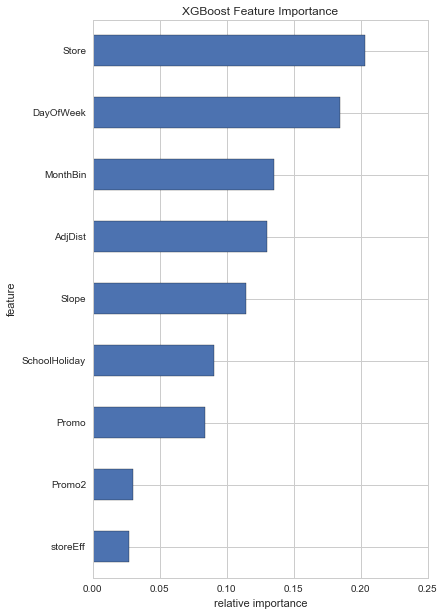

In [454]:
#with the 'corrected adj dist we do much worse.. 
#maybe competition was functioing as a dummy 0/1 variable

feat_import(features, xgb)

#RMSPE: 0.155969
#[9]	train-rmspe:0.398081	eval-rmspe:0.381808
# strange that hte graph looks the same and reported 
#RMSPE isvary diferent from train and eval versions        
# store (raw number) is the most important (.21)

# and store eff is the least (.025)
#slope seems to do pretty well (0.12)
# submitted, scored .13512

In [456]:
#12_11_15 3 XGB  # using raw adj distance without scaling


#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


#train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
#test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
#preprocessing.scale(train_scaled['AdjDist'])
#preprocessing.scale(test_scaled['AdjDist'])



trainXGB(train_scaled, test_scaled, params, features, 'x3')

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996764	eval-rmspe:0.996762
[1]	train-rmspe:0.980757	eval-rmspe:0.980775
[2]	train-rmspe:0.934968	eval-rmspe:0.935059
[3]	train-rmspe:0.848393	eval-rmspe:0.848466
[4]	train-rmspe:0.730652	eval-rmspe:0.730659
[5]	train-rmspe:0.605239	eval-rmspe:0.604376
[6]	train-rmspe:0.499607	eval-rmspe:0.496095
[7]	train-rmspe:0.428992	eval-rmspe:0.422309
[8]	train-rmspe:0.399459	eval-rmspe:0.387442
[9]	train-rmspe:0.398081	eval-rmspe:0.381808
[10]	train-rmspe:0.411444	eval-rmspe:0.391727
[11]	train-rmspe:0.428190	eval-rmspe:0.407250
[12]	train-rmspe:0.440425	eval-rmspe:0.418928
[13]	train-rmspe:0.453508	eval-rmspe:0.430733
[14]	train-rmspe:0.466625	eval-rmspe:0.444330
[15]	train-rmspe:0.471434	eval-rmspe:0.447541
[16]	train-rmspe:0.473172	eval-rmspe:0.448680
[17]	train-rmspe:0.472229	eval-rmspe:0.446996
[18]	train-rmspe:0.474361	eval-rmspe:0.449510
[19]	train-rmspe:0.472704	eval-rmspe:0.447700
[20]	train-rmspe:0.469628	eval

Validating
RMSPE: 0.155969
Make predictions on the test set
the prediction took 1425738107.05 mins


[109]	train-rmspe:0.439199	eval-rmspe:0.412158
Stopping. Best iteration:
[9]	train-rmspe:0.398081	eval-rmspe:0.381808



In [457]:
# no improvemnt 

#RMSPE: 0.155969
#Make predictions on the test set
#the prediction took 1425738107.05 mins
#[109]	train-rmspe:0.439199	eval-rmspe:0.412158
#Stopping. Best iteration:
#[9]	train-rmspe:0.398081	eval-rmspe:0.381808

In [461]:
#12_11_15 4 XGB  # back to 74-78k Adj dist/ 78k

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])


trainXGB(train_scaled, test_scaled, params, features, 'x4')

Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 6.26577123404Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [ ]:
# yeah making adj dist values very high for close stores (almost binary ) gets the algorythm out of a rut

#RMSPE: 0.153767
#Make predictions on the test set
#the prediction took 6.26577123404Mins
#[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [469]:
# try adj dist threshold 10k instead of 5k
#12_11_15 5 XGB  # back to 74-78k Adj dist/ 78k

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])


trainXGB(train_scaled, test_scaled, params, features, 'x5')


Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 6.52663220167Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


In [ ]:
## not better really
#RMSPE: 0.153767
#Make predictions on the test set
#the prediction took 6.52663220167Mins
#[299]	train-rmspe:0.282838	eval-rmspe:0.208909

In [473]:
#try using the old Adjustdist and 5k threshold

# try adj dist threshold 10k instead of 5k
#12_11_15 5 XGB  # back to 74-78k Adj dist/ 78k

#Make a feature list - using simpified features (adjDist, storeEff, MonthBin)
#also added store specific slope (sales x customer ('efficiency'))
features = ['Store', 'DayOfWeek', 'Promo', 
            'SchoolHoliday','Promo2', 
            'storeEff', 'AdjDist','MonthBin', 'Slope']
            #TO DO add these when you get integer days :
            #'OpenDay', 'CompetitorOpenDay', 'CumlDays',
            #'PromoInterval', 'StateHoliday', 'Customers',

# values and model from post https://www.kaggle.com/cast42/rossmann-store-sales/xgboost-in-python-with-rmspe-v2
params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "eta": 0.3,
          "max_depth": 10,
          "subsample": 0.9,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 1301
          }

train_scaled = train_data2
train_scaled.fillna(0, inplace=True)
test_scaled = test_data2
test_scaled.fillna(0, inplace=True)


train_scaled['AdjDist']=train_scaled['AdjDist']/max(train_scaled['AdjDist'])
test_scaled['AdjDist']=test_scaled['AdjDist']/max(test_scaled['AdjDist'])
preprocessing.scale(train_scaled['AdjDist'])
preprocessing.scale(test_scaled['AdjDist'])


trainXGB(train_scaled, test_scaled, params, features, 'x6')



Will train until eval error hasn't decreased in 100 rounds.
[0]	train-rmspe:0.996839	eval-rmspe:0.996841
[1]	train-rmspe:0.981495	eval-rmspe:0.981507
[2]	train-rmspe:0.937684	eval-rmspe:0.937756
[3]	train-rmspe:0.855687	eval-rmspe:0.855651
[4]	train-rmspe:0.741590	eval-rmspe:0.740936
[5]	train-rmspe:0.616604	eval-rmspe:0.614241
[6]	train-rmspe:0.502017	eval-rmspe:0.495805
[7]	train-rmspe:0.413790	eval-rmspe:0.400683
[8]	train-rmspe:0.356339	eval-rmspe:0.335480
[9]	train-rmspe:0.330288	eval-rmspe:0.298510
[10]	train-rmspe:0.321087	eval-rmspe:0.282250
[11]	train-rmspe:0.323501	eval-rmspe:0.278184
[12]	train-rmspe:0.327266	eval-rmspe:0.278979
[13]	train-rmspe:0.330974	eval-rmspe:0.279479
[14]	train-rmspe:0.341681	eval-rmspe:0.284566
[15]	train-rmspe:0.338529	eval-rmspe:0.277152
[16]	train-rmspe:0.338236	eval-rmspe:0.275988
[17]	train-rmspe:0.342089	eval-rmspe:0.278513
[18]	train-rmspe:0.340416	eval-rmspe:0.275412
[19]	train-rmspe:0.336250	eval-rmspe:0.270597
[20]	train-rmspe:0.334671	eval

Validating
RMSPE: 0.153767
Make predictions on the test set
the prediction took 5.96785646677Mins


[299]	train-rmspe:0.282838	eval-rmspe:0.208909


### Model Stacking Attempt

In this attempt 6 models were created including an SVM model, 2x XGB models, and 3x RF models. These models were then combined with the feature matrix and fed into a 2nd stage model another XGB. The hold out performance of this stacked model is then compared to a baseline model to determine if it improves performance.

A number of issues arose that prevented this method from working. Firstly the stage 1 models did not perform particularly well by themselves and needed more individual tuning. Secondly most of them were tree based methods which possibly produce correlated predictions and thus don't combine that effectively.


In [1]:
#Parts of this script come from the XGB benchmark script submitted to the kaggle forum

#ughhhh libraries
import csv
import datetime
from sklearn import preprocessing
import numpy as np
from scipy import sparse
from sklearn.cross_validation import KFold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import LinearSVR
import xgboost as xgb
from sklearn import linear_model
from sklearn import naive_bayes
import time
import pandas as pd

#Load data
train = pd.read_csv('/users/thomasatkins/Documents/MIDS/AML/Rossman/train.csv')
test = pd.read_csv('/users/thomasatkins/Documents/MIDS/AML/Rossman/test.csv')
stores = pd.read_csv('/users/thomasatkins/Documents/MIDS/AML/Rossman/store.csv')

#Join Stores
train = pd.merge(train,stores,on='Store')
test = pd.merge(test,stores,on='Store')

#Remove Sales = 0 Data
train = train[train.Sales>0]

#Convert to log sales
train.Sales = np.log(train.Sales + 1)

#Fill na with 1 for open unknown
train['Open'] = train['Open'].fillna(1)
test['Open'] = test['Open'].fillna(1)

#Add Date Characteristics
date1 = [datetime.datetime.strptime(i,'%Y-%m-%d') for i in train.Date]
date2 = [datetime.datetime.strptime(i,'%Y-%m-%d') for i in test.Date]
train['Day'] = [i.day for i in date1]
train['Month'] = [i.month for i in date1]
train['Year'] = [i.year for i in date1]
test['Day'] = [i.day for i in date2]
test['Month'] = [i.month for i in date2]
test['Year'] = [i.year for i in date2]


#feature engineering - customers per sale and sales per customer by store
def map_cust_per_sale_by_store(dat):
    res = []
    for i in dat:
        res.append([i[0],1.0*float(i[1])/float(i[2]),1.0*float(i[2])/float(i[1])])
    return res

#this reduce function calculates the median customers per sale and median sales per customer for all stores
def reduce_by_key(sorted_kv):
    key=1
    values_in_key1=[]
    values_in_key2=[]
    results=[]
    for i in sorted_kv:
        if i[0]==key:
            values_in_key1.append(i[1])
            values_in_key2.append(i[2])
        if i[0]!=key:
            results.append([key,np.median(values_in_key1),np.median(values_in_key2)])
            key = i[0]
            values_in_key1=[i[1]]
            values_in_key2=[i[2]]
    return results


#another error function
def rmspe(y, yhat):
	return np.sqrt(np.mean((yhat/y-1) ** 2))

#another error function
def rmspe_xg(yhat, y):
	y = np.expm1(y.get_label())
	yhat = np.expm1(yhat)
	return "rmspe", rmspe(y,yhat)

#create the tuples for input into the map-reduce job
dat = zip(train.Store,train.Sales,train.Customers)

#mini MapReduce Job... map | sort | reduce
kv = map_cust_per_sale_by_store(dat)
kv.sort(key=lambda x: x[0])
store_cps_spc = reduce_by_key(kv)[1:]

#covert the results into a pandas dataframe for merging
pd_store_cps_spc = pd.DataFrame(store_cps_spc,columns=['Store','ratio1','ratio2'])

train = pd.merge(train,pd_store_cps_spc,on='Store',how='left')
test = pd.merge(test,pd_store_cps_spc,on='Store',how='left')

#fix NAs (all data)
train = train.fillna(0)
test = test.fillna(0)

#label encode
mappings = {'0':0, 'a':1, 'b':2, 'c':3, 'd':4}
train.StoreType.replace(mappings, inplace=True)
train.Assortment.replace(mappings, inplace=True)
train.StateHoliday.replace(mappings, inplace=True)
mappings2 = {'Jan,Apr,Jul,Oct':1, 'Feb,May,Aug,Nov':2, 'Mar,Jun,Sept,Dec':3}
train.PromoInterval.replace(mappings2,inplace=True)

test.StoreType.replace(mappings, inplace=True)
test.Assortment.replace(mappings, inplace=True)
test.StateHoliday.replace(mappings, inplace=True)
test.PromoInterval.replace(mappings2,inplace=True)


cat_vars = ['DayOfWeek','Promo','StateHoliday','SchoolHoliday','StoreType','Assortment','CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear','Promo2','Promo2SinceWeek','Promo2SinceYear','PromoInterval','Day','Month','Year']


num_vars = ['Open','Store','CompetitionDistance','ratio1','ratio2']


#5x Cross Validation with XGB produced significantly worse test set error than compared to the train test split below
#i've concluded from this that much is gained by training on 98.8% data vs only training on 80% data
X_trn, X_val = train_test_split(train, test_size=0.012, random_state=10)

#We first train a number of smaller models including svm,xgb,rf.
print 'Training Stage 1 Models'

#train svm
svm1 = LinearSVR(verbose=True)
svm1.fit(X_trn[cat_vars+num_vars],X_trn['Sales'])
svm1_feature = svm1.predict(train[cat_vars+num_vars])
preds = svm1.predict(X_val[cat_vars+num_vars])
print 'svm ',(np.mean(((np.exp(preds)-np.exp(X_val['Sales']))/(np.exp(X_val['Sales'])+1))**2))**0.5


#train xgb
dtrain = xgb.DMatrix(X_trn[cat_vars+num_vars],X_trn['Sales'])
dvalid = xgb.DMatrix(X_val[cat_vars+num_vars],X_val['Sales'])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

num_boost_round = 50
params1 = {"objective": "reg:linear","booster" : "gbtree",
"eta": 0.5,"max_depth": 2,"subsample": 0.5,"colsample_bytree": 0.4,
"nthread":4,"silent": 1,"seed": 1301}
gbm1 = xgb.train(params1, dtrain, num_boost_round, evals=watchlist,early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)

num_boost_round = 50
params2 = {"objective": "reg:linear","booster" : "gbtree",
"eta": 0.5,"max_depth": 6,"subsample": 0.5,"colsample_bytree": 0.9,
"nthread":4,"silent": 1,"seed": 1301}
gbm2 = xgb.train(params2, dtrain, num_boost_round, evals=watchlist,early_stopping_rounds=50, feval=rmspe_xg, verbose_eval=True)


xgb1_feature = gbm1.predict(xgb.DMatrix(train[cat_vars+num_vars]))
xgb2_feature = gbm2.predict(xgb.DMatrix(train[cat_vars+num_vars]))


#RandomForestRegressor
X,Y = X_trn[cat_vars+num_vars],X_trn['Sales']
#train model
rfm1 = RandomForestRegressor(n_estimators=77,max_depth=3,n_jobs=-1,verbose=1)
rfm1.fit(X,Y)
rfm1_feature = rfm1.predict(train[cat_vars+num_vars])

rfm2 = RandomForestRegressor(n_estimators=55,max_depth=5,n_jobs=-1,verbose=1)
rfm2.fit(X,Y)
rfm2_feature = rfm2.predict(train[cat_vars+num_vars])

rfm3 = RandomForestRegressor(n_estimators=33,max_depth=10,n_jobs=-1,verbose=1)
rfm3.fit(X,Y)
rfm3_feature = rfm3.predict(train[cat_vars+num_vars])

#The outputs of each of the models are combined with the other training variables
train['svm1'] = svm1_feature
train['xgb1'] = xgb1_feature
train['xgb2'] = xgb2_feature
train['rfm1'] = rfm1_feature
train['rfm2'] = rfm2_feature
train['rfm3'] = rfm3_feature

#Again the data is split 
X_trn, X_val = train_test_split(train, test_size=0.012, random_state=10)


print 'Baseline: '
#In this XGB we do not include the new models from above. This servers as a baseline result
#This model is tuned identically to the tuned model below.
dtrain = xgb.DMatrix(X_trn[cat_vars+num_vars],X_trn['Sales'])
dvalid = xgb.DMatrix(X_val[cat_vars+num_vars],X_val['Sales'])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

num_boost_round = 300
params3 = {"objective": "reg:linear","booster" : "gbtree",
"eta": 0.3,"max_depth": 10,"subsample": 0.95,"colsample_bytree": 0.9,
"nthread":4,"silent": 1,"seed": 1301}
gbm3 = xgb.train(params3, dtrain, num_boost_round, evals=watchlist,early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

preds = gbm3.predict(dvalid)
#score
Y_val = dvalid.get_label()
rmspe1 = (np.mean(((np.exp(preds)-np.exp(Y_val))/(np.exp(Y_val)+1))**2))**0.5
print 'score: ',rmspe1


print 'Stacked Model:'
#The outputs of the above models are fed in as inputs to another XGB model
dtrain = xgb.DMatrix(X_trn[cat_vars+num_vars+['xgb1','xgb2','rfm1','rfm2','rfm3','svm1']],X_trn['Sales'])
dvalid = xgb.DMatrix(X_val[cat_vars+num_vars+['xgb1','xgb2','rfm1','rfm2','rfm3','svm1']],X_val['Sales'])
watchlist = [(dtrain, 'train'), (dvalid, 'eval')]

num_boost_round = 300
params3 = {"objective": "reg:linear","booster" : "gbtree",
"eta": 0.3,"max_depth": 10,"subsample": 0.95,"colsample_bytree": 0.9,
"nthread":4,"silent": 1,"seed": 1301}
gbm3 = xgb.train(params3, dtrain, num_boost_round, evals=watchlist,early_stopping_rounds=100, feval=rmspe_xg, verbose_eval=True)

preds = gbm3.predict(dvalid)
#score
Y_val = dvalid.get_label()
rmspe1 = (np.mean(((np.exp(preds)-np.exp(Y_val))/(np.exp(Y_val)+1))**2))**0.5
print 'score: ',rmspe1


#baseline model 0.09238 OOS score
#stacked model 0.09829 OOS score

#stacked model didn't improve. this model is overfitting the data since train error
#is 0.074728 for baseline and 0.074210 for stacked model



ImportError: No module named xgboost

**3e- Ensemble implementation**

**4-choose a final implementation **